In [1]:
import torch
from torch import embedding, nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
from torch import nn
from tqdm import tqdm
from unet import UNet
from discriminator import Discriminator
from baseline import FaceRecognizer
from preprocessing import *
from preprocessing_GAN import *

In [2]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [3]:
d, l = discriminator_make_dataset()

In [4]:
def train_discriminator(model, data, targets, optimizer, criterion):  
    model.train()
    epoch_loss = 0
    sampling = list(range(data.shape[0]))
    random.shuffle(sampling)
    print("training ...")
    for i, selected_batch_index in tqdm(enumerate(sampling)):
        optimizer.zero_grad()
        z = model.forward(data[selected_batch_index])
        loss=criterion(z,targets[selected_batch_index].long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss

In [5]:
training_losses = []
def train_discriminator_eps(model, eps, lr, reg, train_data, train_target):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=reg, nesterov=False)
    criterion = nn.CrossEntropyLoss(reduction = 'sum')
    best_train_loss = 999999
    for epoch in range(eps):  
        print("epoch start: ", epoch)  
        start_time = time.time()
        training_loss = train_discriminator(model, train_data, train_target, optimizer, criterion)
        training_losses.append(training_loss)  
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        torch.save(model.state_dict(), 'best_model_discriminator.pt')
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
        print(f'\tTrain Loss: {training_loss:.3f}')

In [6]:
train_discriminator_eps(discriminator, 20, 0.001, 0.00001, d, l)

epoch start:  0
training ...


400it [00:01, 366.25it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 111.248
epoch start:  1
training ...


400it [00:01, 352.13it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.627
epoch start:  2
training ...


400it [00:01, 352.80it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.245
epoch start:  3
training ...


400it [00:01, 355.90it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.144
epoch start:  4
training ...


400it [00:01, 348.47it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.101
epoch start:  5
training ...


400it [00:01, 364.32it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.077
epoch start:  6
training ...


400it [00:01, 356.06it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.061
epoch start:  7
training ...


400it [00:01, 365.49it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.051
epoch start:  8
training ...


400it [00:01, 353.21it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.043
epoch start:  9
training ...


400it [00:01, 372.37it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.038
epoch start:  10
training ...


400it [00:00, 414.97it/s]


Epoch: 11 | Time: 0m 0s	Train Loss: 0.033
epoch start:  11
training ...


400it [00:01, 349.58it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.030
epoch start:  12
training ...


400it [00:01, 365.46it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.027
epoch start:  13
training ...


400it [00:01, 348.53it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.024
epoch start:  14
training ...


400it [00:01, 360.28it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.022
epoch start:  15
training ...


400it [00:01, 359.57it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.020
epoch start:  16
training ...


400it [00:01, 350.26it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.019
epoch start:  17
training ...


400it [00:01, 347.06it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.018
epoch start:  18
training ...


400it [00:01, 387.13it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.017
epoch start:  19
training ...


400it [00:01, 357.28it/s]

Epoch: 20 | Time: 0m 1s	Train Loss: 0.015


In [7]:
torch.softmax(discriminator(d[3]),-1)

tensor([[9.9999e-01, 5.7914e-06]], grad_fn=<SoftmaxBackward>)

In [8]:
def evolve_generator_1ep(generator, faceRecognizer, discriminator, attack_targets, optimizer, criterion, alpha):
    gan_input = torch.normal(0, 1, size=(1,1,64, 64)) # noise
    faceRecognizer.eval()
    discriminator.eval()
    generator.train()
    optimizer.zero_grad()
    generated_imgs = generator.forward(gan_input)
    loss = 0
    for i in range(attack_targets.shape[0]):
        z1 = faceRecognizer.forward(generated_imgs[0][i].reshape(1,1,64,64))
        loss+=criterion(z1,attack_targets[i])
        z2 = discriminator.forward(generated_imgs[0][i].reshape(1,1,64,64))
        loss+= alpha*criterion(z2,torch.tensor([1]))
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()/len(attack_targets) 
    return epoch_loss
    

In [9]:
def evolve_generator(eps, lr, reg, lr_decay, alpha):
    for epoch in range(eps): 
        optimizer = optim.SGD(generator.parameters(), lr=lr*lr_decay**epoch, momentum=0.9, weight_decay=reg, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss = 0
        epoch_loss += evolve_generator_1ep(generator, faceRecognizer, discriminator, attack_targets, optimizer, criterion, alpha)
        print("loss(generator): ", epoch_loss)



In [42]:
evolve_generator(10, 0.001, 0.0002, 0.98, 1)

loss(generator):  0.015215037763118744
loss(generator):  0.02202201932668686
loss(generator):  0.016499873995780946
loss(generator):  0.016242820024490356
loss(generator):  0.0181690514087677
loss(generator):  0.019580133259296417
loss(generator):  0.016408704221248627
loss(generator):  0.021648530662059785
loss(generator):  0.016303357481956483
loss(generator):  0.01565176695585251


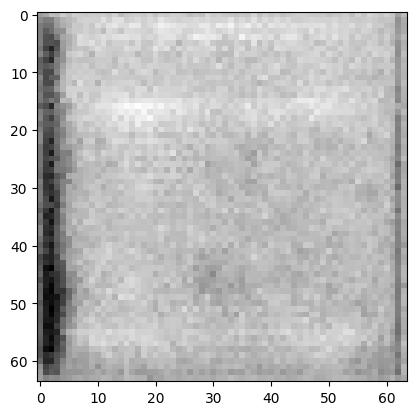

In [49]:
generated_image(0)

In [45]:
print_confidence(9)

tensor([[8.9739e-05, 9.8964e-10, 6.5881e-05, 2.9043e-07, 5.4812e-05, 7.0691e-09,
         3.7996e-07, 1.5321e-05, 1.0682e-04, 9.9727e-01, 7.2448e-09, 1.5769e-06,
         7.9498e-04, 1.1906e-10, 9.6587e-07, 3.5448e-06, 8.7369e-07, 8.1408e-10,
         7.5797e-08, 1.7730e-06, 7.3639e-05, 3.1185e-05, 4.8613e-05, 8.8653e-05,
         4.8201e-06, 2.0098e-09, 1.3097e-08, 8.9983e-06, 3.6599e-04, 2.6959e-04,
         3.8055e-06, 1.0024e-11, 3.4244e-05, 5.6636e-08, 5.7562e-04, 1.6870e-05,
         2.3719e-06, 1.2598e-07, 6.7295e-06, 5.6894e-05]],
       grad_fn=<SoftmaxBackward>)


In [30]:
torch.softmax(discriminator.forward(generate(1).reshape(1,1,64,64)),-1)

tensor([[0.0146, 0.9854]], grad_fn=<SoftmaxBackward>)

In [46]:
d, l = discriminator_make_dataset()

In [47]:
train_discriminator_eps(discriminator, 20, 0.001, 0.00001, d, l)

epoch start:  0
training ...


400it [00:01, 358.26it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 30.420
epoch start:  1
training ...


400it [00:01, 347.17it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.854
epoch start:  2
training ...


400it [00:01, 351.36it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.237
epoch start:  3
training ...


400it [00:01, 351.02it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.133
epoch start:  4
training ...


400it [00:01, 320.57it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.092
epoch start:  5
training ...


400it [00:01, 295.25it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.073
epoch start:  6
training ...


400it [00:01, 377.53it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.059
epoch start:  7
training ...


400it [00:00, 405.06it/s]


Epoch: 08 | Time: 0m 0s	Train Loss: 0.051
epoch start:  8
training ...


400it [00:01, 348.70it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.044
epoch start:  9
training ...


400it [00:01, 317.63it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.039
epoch start:  10
training ...


400it [00:01, 349.04it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.034
epoch start:  11
training ...


400it [00:01, 337.86it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.031
epoch start:  12
training ...


400it [00:01, 338.19it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.028
epoch start:  13
training ...


400it [00:01, 349.08it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.025
epoch start:  14
training ...


400it [00:01, 349.50it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.024
epoch start:  15
training ...


400it [00:01, 356.70it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.022
epoch start:  16
training ...


400it [00:01, 379.65it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.020
epoch start:  17
training ...


400it [00:01, 347.37it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.019
epoch start:  18
training ...


400it [00:01, 387.06it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.018
epoch start:  19
training ...


400it [00:01, 344.73it/s]

Epoch: 20 | Time: 0m 1s	Train Loss: 0.017


In [48]:
torch.softmax(discriminator.forward(generate(1).reshape(1,1,64,64)),-1)

tensor([[9.9984e-01, 1.5834e-04]], grad_fn=<SoftmaxBackward>)

In [50]:
for i in range(10):
    evolve_generator(100, 0.001, 0.0002, 0.99, 1)
    d, l = discriminator_make_dataset()
    train_discriminator_eps(discriminator, 20, 0.001, 0.00001, d, l)

loss(generator):  13.140379333496094
loss(generator):  3.8282455444335937
loss(generator):  4.493832015991211
loss(generator):  4.506063842773438
loss(generator):  1.4154654502868653
loss(generator):  0.9050755500793457
loss(generator):  0.3694225549697876
loss(generator):  0.30307574272155763
loss(generator):  0.3930603265762329
loss(generator):  0.22828915119171142
loss(generator):  0.16445902585983277
loss(generator):  0.18272926807403564
loss(generator):  0.12684937715530395
loss(generator):  0.1611706495285034
loss(generator):  0.14723632335662842
loss(generator):  0.07818771600723266
loss(generator):  0.0935351550579071
loss(generator):  0.08281315565109253
loss(generator):  0.09202256798744202
loss(generator):  0.08970258235931397
loss(generator):  0.09559237957000732
loss(generator):  0.0879769742488861
loss(generator):  0.06135236620903015
loss(generator):  0.05573158860206604
loss(generator):  0.09687843322753906
loss(generator):  0.07004370093345642
loss(generator):  0.04968

400it [00:01, 356.47it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 39.907
epoch start:  1
training ...


400it [00:01, 359.33it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.692
epoch start:  2
training ...


400it [00:01, 360.44it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.332
epoch start:  3
training ...


400it [00:01, 348.00it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.214
epoch start:  4
training ...


400it [00:01, 348.54it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.151
epoch start:  5
training ...


400it [00:01, 346.62it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.119
epoch start:  6
training ...


400it [00:01, 347.02it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.096
epoch start:  7
training ...


400it [00:01, 349.20it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.081
epoch start:  8
training ...


400it [00:01, 348.50it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.069
epoch start:  9
training ...


400it [00:01, 348.58it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.060
epoch start:  10
training ...


400it [00:01, 349.34it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.053
epoch start:  11
training ...


400it [00:01, 360.48it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.048
epoch start:  12
training ...


400it [00:01, 348.93it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.043
epoch start:  13
training ...


400it [00:01, 346.47it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.039
epoch start:  14
training ...


400it [00:01, 344.27it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.036
epoch start:  15
training ...


400it [00:01, 343.18it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.033
epoch start:  16
training ...


400it [00:01, 345.13it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.031
epoch start:  17
training ...


400it [00:01, 342.19it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.029
epoch start:  18
training ...


400it [00:01, 344.85it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.027
epoch start:  19
training ...


400it [00:01, 349.72it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.025
loss(generator):  11.523363494873047
loss(generator):  4.413129806518555
loss(generator):  5.921683120727539
loss(generator):  3.397713851928711
loss(generator):  1.712110710144043
loss(generator):  1.4491868972778321
loss(generator):  0.7966522216796875
loss(generator):  0.13973735570907592
loss(generator):  0.10020610094070434
loss(generator):  0.08719781041145325
loss(generator):  0.08473474383354188
loss(generator):  0.059292304515838626
loss(generator):  0.05567131638526916
loss(generator):  0.06315367817878723
loss(generator):  0.05837133526802063
loss(generator):  0.052097129821777347
loss(generator):  0.046011495590209964
loss(generator):  0.04460801780223846
loss(generator):  0.06374012231826783
loss(generator):  0.05289480686187744
loss(generator):  0.037680605053901674
loss(generator):  0.03892960250377655
loss(generator):  0.03720355033874512
loss(generator):  0.03311131596565246
loss(generator):  0.03200936913490295
loss(generator)

400it [00:01, 328.04it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 43.864
epoch start:  1
training ...


400it [00:01, 328.86it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.829
epoch start:  2
training ...


400it [00:01, 338.18it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.380
epoch start:  3
training ...


400it [00:01, 346.33it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.246
epoch start:  4
training ...


400it [00:01, 340.10it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.187
epoch start:  5
training ...


400it [00:01, 344.14it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.142
epoch start:  6
training ...


400it [00:01, 344.81it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.116
epoch start:  7
training ...


400it [00:01, 345.18it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.097
epoch start:  8
training ...


400it [00:01, 345.44it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.084
epoch start:  9
training ...


400it [00:01, 360.92it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.074
epoch start:  10
training ...


400it [00:01, 358.78it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.064
epoch start:  11
training ...


400it [00:01, 349.67it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.058
epoch start:  12
training ...


400it [00:01, 324.73it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.052
epoch start:  13
training ...


400it [00:01, 332.82it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.047
epoch start:  14
training ...


400it [00:01, 332.88it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.043
epoch start:  15
training ...


400it [00:01, 346.36it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.040
epoch start:  16
training ...


400it [00:01, 347.89it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.037
epoch start:  17
training ...


400it [00:01, 345.82it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.035
epoch start:  18
training ...


400it [00:01, 348.22it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.032
epoch start:  19
training ...


400it [00:01, 348.63it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.030
loss(generator):  11.195771026611329
loss(generator):  5.826727294921875
loss(generator):  3.229897689819336
loss(generator):  1.0472310066223145
loss(generator):  0.46922898292541504
loss(generator):  0.5055610179901123
loss(generator):  0.23156869411468506
loss(generator):  0.12402000427246093
loss(generator):  0.0744965136051178
loss(generator):  0.06518298983573914
loss(generator):  0.07643629908561707
loss(generator):  0.06322153806686401
loss(generator):  0.0568109929561615
loss(generator):  0.0737649917602539
loss(generator):  0.06518335938453675
loss(generator):  0.06132776141166687
loss(generator):  0.04667437374591828
loss(generator):  0.05516560077667236
loss(generator):  0.04644725918769836
loss(generator):  0.054714351892471313
loss(generator):  0.04016004502773285
loss(generator):  0.054560667276382445
loss(generator):  0.03619296848773956
loss(generator):  0.029799127578735353
loss(generator):  0.04235981702804566
loss(generator)

400it [00:01, 331.70it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 38.461
epoch start:  1
training ...


400it [00:01, 347.39it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.551
epoch start:  2
training ...


400it [00:01, 342.76it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.297
epoch start:  3
training ...


400it [00:01, 343.53it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.198
epoch start:  4
training ...


400it [00:01, 333.02it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.146
epoch start:  5
training ...


400it [00:01, 305.87it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.118
epoch start:  6
training ...


400it [00:01, 307.54it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.097
epoch start:  7
training ...


400it [00:01, 372.56it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.082
epoch start:  8
training ...


400it [00:01, 358.52it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.071
epoch start:  9
training ...


400it [00:00, 410.29it/s]


Epoch: 10 | Time: 0m 0s	Train Loss: 0.062
epoch start:  10
training ...


400it [00:00, 414.47it/s]


Epoch: 11 | Time: 0m 0s	Train Loss: 0.055
epoch start:  11
training ...


400it [00:01, 334.52it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.050
epoch start:  12
training ...


400it [00:01, 341.67it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.045
epoch start:  13
training ...


400it [00:01, 342.21it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.041
epoch start:  14
training ...


400it [00:01, 327.40it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.038
epoch start:  15
training ...


400it [00:01, 336.63it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.035
epoch start:  16
training ...


400it [00:01, 342.51it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.033
epoch start:  17
training ...


400it [00:01, 342.96it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.031
epoch start:  18
training ...


400it [00:01, 341.93it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.029
epoch start:  19
training ...


400it [00:01, 342.41it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.027
loss(generator):  12.239971160888672
loss(generator):  2.3540578842163087
loss(generator):  4.492401123046875
loss(generator):  4.460731506347656
loss(generator):  1.1008567810058594
loss(generator):  0.10569074153900146
loss(generator):  0.03913563191890716
loss(generator):  0.0326753169298172
loss(generator):  0.020955373346805573
loss(generator):  0.0326373428106308
loss(generator):  0.01904318630695343
loss(generator):  0.02196904718875885
loss(generator):  0.018401604890823365
loss(generator):  0.017640399932861327
loss(generator):  0.016783663630485536
loss(generator):  0.016182664036750793
loss(generator):  0.012309151887893676
loss(generator):  0.011959443986415862
loss(generator):  0.009960446506738663
loss(generator):  0.012101534008979797
loss(generator):  0.009900372475385666
loss(generator):  0.011672767251729966
loss(generator):  0.00930097997188568
loss(generator):  0.01237162873148918
loss(generator):  0.008151436597108841
loss(

400it [00:01, 339.82it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 94.506
epoch start:  1
training ...


400it [00:01, 329.97it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.529
epoch start:  2
training ...


400it [00:01, 330.59it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.234
epoch start:  3
training ...


400it [00:01, 330.75it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.151
epoch start:  4
training ...


400it [00:01, 335.53it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.111
epoch start:  5
training ...


400it [00:01, 350.36it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.087
epoch start:  6
training ...


400it [00:01, 347.90it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.071
epoch start:  7
training ...


400it [00:01, 339.14it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.060
epoch start:  8
training ...


400it [00:01, 334.76it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.052
epoch start:  9
training ...


400it [00:01, 341.46it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.045
epoch start:  10
training ...


400it [00:01, 332.92it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.040
epoch start:  11
training ...


400it [00:01, 345.84it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.036
epoch start:  12
training ...


400it [00:01, 345.37it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.033
epoch start:  13
training ...


400it [00:01, 347.14it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.030
epoch start:  14
training ...


400it [00:01, 345.18it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.028
epoch start:  15
training ...


400it [00:01, 345.42it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.025
epoch start:  16
training ...


400it [00:01, 348.08it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.024
epoch start:  17
training ...


400it [00:01, 348.16it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.022
epoch start:  18
training ...


400it [00:01, 348.10it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.021
epoch start:  19
training ...


400it [00:01, 347.96it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.019
loss(generator):  10.729071807861327
loss(generator):  2.126210403442383
loss(generator):  1.5348273277282716
loss(generator):  0.4734079360961914
loss(generator):  0.4914811134338379
loss(generator):  0.15937650203704834
loss(generator):  0.08040511608123779
loss(generator):  0.07883347868919373
loss(generator):  0.0415419340133667
loss(generator):  0.03343304097652435
loss(generator):  0.03241958916187286
loss(generator):  0.041230741143226626
loss(generator):  0.03525454699993134
loss(generator):  0.03898565471172333
loss(generator):  0.03990357518196106
loss(generator):  0.024802812933921815
loss(generator):  0.023216772079467773
loss(generator):  0.026640158891677857
loss(generator):  0.028576400876045228
loss(generator):  0.022628825902938843
loss(generator):  0.014578014612197876
loss(generator):  0.017292214930057524
loss(generator):  0.023825237154960634
loss(generator):  0.024701894819736482
loss(generator):  0.017885689437389374
loss

400it [00:01, 352.64it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 77.970
epoch start:  1
training ...


400it [00:01, 352.44it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.087
epoch start:  2
training ...


400it [00:01, 354.86it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.401
epoch start:  3
training ...


400it [00:01, 354.85it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.245
epoch start:  4
training ...


400it [00:01, 350.47it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.173
epoch start:  5
training ...


400it [00:01, 349.51it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.132
epoch start:  6
training ...


400it [00:01, 347.53it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.107
epoch start:  7
training ...


400it [00:01, 333.42it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.088
epoch start:  8
training ...


400it [00:01, 332.37it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.075
epoch start:  9
training ...


400it [00:01, 333.22it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.065
epoch start:  10
training ...


400it [00:01, 333.04it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.057
epoch start:  11
training ...


400it [00:01, 360.75it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.051
epoch start:  12
training ...


400it [00:01, 389.21it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.046
epoch start:  13
training ...


400it [00:01, 385.91it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.042
epoch start:  14
training ...


400it [00:01, 384.95it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.038
epoch start:  15
training ...


400it [00:01, 380.86it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.035
epoch start:  16
training ...


400it [00:01, 305.48it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.032
epoch start:  17
training ...


400it [00:01, 344.61it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.030
epoch start:  18
training ...


400it [00:01, 352.35it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.028
epoch start:  19
training ...


400it [00:01, 352.89it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.026
loss(generator):  10.986383819580078
loss(generator):  5.789445495605468
loss(generator):  0.7858428478240966
loss(generator):  0.1761348843574524
loss(generator):  0.1041025161743164
loss(generator):  0.11406130790710449
loss(generator):  0.1121260643005371
loss(generator):  0.0667628824710846
loss(generator):  0.05995391607284546
loss(generator):  0.056822198629379275
loss(generator):  0.04507209658622742
loss(generator):  0.05694079399108887
loss(generator):  0.04528592228889465
loss(generator):  0.060942769050598145
loss(generator):  0.05650574564933777
loss(generator):  0.03383184373378754
loss(generator):  0.03486150503158569
loss(generator):  0.04249942898750305
loss(generator):  0.037441146373748777
loss(generator):  0.028436869382858276
loss(generator):  0.032519981265068054
loss(generator):  0.03198303282260895
loss(generator):  0.025214359164237976
loss(generator):  0.0248758926987648
loss(generator):  0.02663012742996216
loss(genera

400it [00:01, 330.74it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 56.532
epoch start:  1
training ...


400it [00:01, 330.84it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 22.860
epoch start:  2
training ...


400it [00:01, 342.69it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 1.274
epoch start:  3
training ...


400it [00:01, 346.50it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.375
epoch start:  4
training ...


400it [00:01, 345.93it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.189
epoch start:  5
training ...


400it [00:01, 345.83it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.132
epoch start:  6
training ...


400it [00:01, 350.40it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.100
epoch start:  7
training ...


400it [00:01, 350.65it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.081
epoch start:  8
training ...


400it [00:01, 351.11it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.067
epoch start:  9
training ...


400it [00:01, 348.25it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.057
epoch start:  10
training ...


400it [00:01, 344.21it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.050
epoch start:  11
training ...


400it [00:01, 347.45it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.044
epoch start:  12
training ...


400it [00:01, 347.44it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.040
epoch start:  13
training ...


400it [00:01, 350.77it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.036
epoch start:  14
training ...


400it [00:01, 350.80it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.033
epoch start:  15
training ...


400it [00:01, 349.19it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.030
epoch start:  16
training ...


400it [00:01, 345.38it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.028
epoch start:  17
training ...


400it [00:01, 337.71it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.026
epoch start:  18
training ...


400it [00:01, 348.71it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.024
epoch start:  19
training ...


400it [00:01, 349.17it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.022
loss(generator):  12.564967346191406
loss(generator):  5.814962387084961
loss(generator):  2.315746307373047
loss(generator):  1.1268928527832032
loss(generator):  0.6114439964294434
loss(generator):  0.6287505626678467
loss(generator):  0.4597261905670166
loss(generator):  0.3152731657028198
loss(generator):  0.23635098934173585
loss(generator):  0.17712897062301636
loss(generator):  0.15753403902053834
loss(generator):  0.09623192548751831
loss(generator):  0.10577365159988403
loss(generator):  0.07348746061325073
loss(generator):  0.060138595104217527
loss(generator):  0.06006285548210144
loss(generator):  0.05761762857437134
loss(generator):  0.05014989376068115
loss(generator):  0.0599938154220581
loss(generator):  0.03455149233341217
loss(generator):  0.043747901916503906
loss(generator):  0.037520086765289305
loss(generator):  0.03288359344005585
loss(generator):  0.03756933212280274
loss(generator):  0.0352291464805603
loss(generator): 

400it [00:01, 329.80it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 44.253
epoch start:  1
training ...


400it [00:01, 345.02it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.251
epoch start:  2
training ...


400it [00:01, 348.42it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.347
epoch start:  3
training ...


400it [00:01, 348.02it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.226
epoch start:  4
training ...


400it [00:01, 347.28it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.166
epoch start:  5
training ...


400it [00:01, 349.37it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.132
epoch start:  6
training ...


400it [00:01, 347.30it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.107
epoch start:  7
training ...


400it [00:01, 348.87it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.092
epoch start:  8
training ...


400it [00:01, 344.81it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.079
epoch start:  9
training ...


400it [00:01, 347.39it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.069
epoch start:  10
training ...


400it [00:01, 333.82it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.062
epoch start:  11
training ...


400it [00:01, 332.69it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.056
epoch start:  12
training ...


400it [00:01, 333.03it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.051
epoch start:  13
training ...


400it [00:01, 333.12it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.046
epoch start:  14
training ...


400it [00:01, 324.51it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.043
epoch start:  15
training ...


400it [00:01, 341.18it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.040
epoch start:  16
training ...


400it [00:01, 343.59it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.037
epoch start:  17
training ...


400it [00:01, 339.81it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.035
epoch start:  18
training ...


400it [00:01, 341.33it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.033
epoch start:  19
training ...


400it [00:01, 341.60it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.031
loss(generator):  11.695948791503906
loss(generator):  3.5407791137695312
loss(generator):  1.4472337722778321
loss(generator):  0.36727333068847656
loss(generator):  0.41439332962036135
loss(generator):  0.353849458694458
loss(generator):  0.08197948932647706
loss(generator):  0.12541228532791138
loss(generator):  0.09891976118087768
loss(generator):  0.0675538182258606
loss(generator):  0.06012883186340332
loss(generator):  0.0486299991607666
loss(generator):  0.05209551453590393
loss(generator):  0.02908334732055664
loss(generator):  0.04095056354999542
loss(generator):  0.02109299600124359
loss(generator):  0.026751512289047243
loss(generator):  0.03133409321308136
loss(generator):  0.03410875201225281
loss(generator):  0.0234401673078537
loss(generator):  0.02677028179168701
loss(generator):  0.019984115660190583
loss(generator):  0.021051175892353058
loss(generator):  0.02554044723510742
loss(generator):  0.024685709178447722
loss(generat

400it [00:01, 331.63it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 59.185
epoch start:  1
training ...


400it [00:01, 330.76it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.720
epoch start:  2
training ...


400it [00:01, 331.20it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.352
epoch start:  3
training ...


400it [00:01, 342.41it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.225
epoch start:  4
training ...


400it [00:01, 341.25it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.162
epoch start:  5
training ...


400it [00:01, 343.26it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.127
epoch start:  6
training ...


400it [00:01, 350.82it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.103
epoch start:  7
training ...


400it [00:01, 348.47it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.087
epoch start:  8
training ...


400it [00:01, 348.14it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.075
epoch start:  9
training ...


400it [00:01, 352.04it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.065
epoch start:  10
training ...


400it [00:01, 350.97it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.058
epoch start:  11
training ...


400it [00:01, 352.02it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.052
epoch start:  12
training ...


400it [00:01, 351.36it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.047
epoch start:  13
training ...


400it [00:01, 351.82it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.043
epoch start:  14
training ...


400it [00:01, 338.89it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.039
epoch start:  15
training ...


400it [00:01, 333.70it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.036
epoch start:  16
training ...


400it [00:01, 334.07it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.034
epoch start:  17
training ...


400it [00:01, 348.64it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.032
epoch start:  18
training ...


400it [00:01, 334.71it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.030
epoch start:  19
training ...


400it [00:01, 334.00it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.028
loss(generator):  11.257952117919922
loss(generator):  5.346768569946289
loss(generator):  2.0473146438598633
loss(generator):  1.5191582679748534
loss(generator):  3.636771392822266
loss(generator):  2.858859634399414
loss(generator):  2.104599189758301
loss(generator):  0.7168153762817383
loss(generator):  0.2631508827209473
loss(generator):  0.18447587490081788
loss(generator):  0.21889467239379884
loss(generator):  0.11536135673522949
loss(generator):  0.12535040378570556
loss(generator):  0.11429804563522339
loss(generator):  0.088548344373703
loss(generator):  0.07220629453659058
loss(generator):  0.08033104538917542
loss(generator):  0.08890848755836486
loss(generator):  0.053379154205322264
loss(generator):  0.053581762313842776
loss(generator):  0.062477147579193114
loss(generator):  0.06108636260032654
loss(generator):  0.051221489906311035
loss(generator):  0.05082275867462158
loss(generator):  0.05859975218772888
loss(generator):  0

400it [00:01, 344.20it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 68.766
epoch start:  1
training ...


400it [00:01, 344.64it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.658
epoch start:  2
training ...


400it [00:01, 343.45it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.331
epoch start:  3
training ...


400it [00:01, 339.69it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.211
epoch start:  4
training ...


400it [00:01, 339.12it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.154
epoch start:  5
training ...


400it [00:01, 330.01it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.122
epoch start:  6
training ...


400it [00:01, 341.07it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.099
epoch start:  7
training ...


400it [00:01, 327.25it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.084
epoch start:  8
training ...


400it [00:01, 329.27it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.072
epoch start:  9
training ...


400it [00:01, 298.69it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.063
epoch start:  10
training ...


400it [00:01, 331.71it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.056
epoch start:  11
training ...


400it [00:01, 331.24it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.050
epoch start:  12
training ...


400it [00:01, 325.66it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.046
epoch start:  13
training ...


400it [00:01, 331.10it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.042
epoch start:  14
training ...


400it [00:01, 331.48it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.039
epoch start:  15
training ...


400it [00:01, 331.72it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.036
epoch start:  16
training ...


400it [00:01, 330.92it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.033
epoch start:  17
training ...


400it [00:01, 330.57it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.031
epoch start:  18
training ...


400it [00:01, 331.51it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.029
epoch start:  19
training ...


400it [00:01, 331.00it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.027
loss(generator):  10.039706420898437
loss(generator):  1.212716293334961
loss(generator):  0.5635462760925293
loss(generator):  0.08956333994865417
loss(generator):  0.062251389026641846
loss(generator):  0.03246093392372131
loss(generator):  0.03247175812721252
loss(generator):  0.0376206636428833
loss(generator):  0.032450294494628905
loss(generator):  0.03718612790107727
loss(generator):  0.028234460949897768
loss(generator):  0.03131127655506134
loss(generator):  0.03328927457332611
loss(generator):  0.01643674075603485
loss(generator):  0.0230597585439682
loss(generator):  0.019357924163341523
loss(generator):  0.03091224730014801
loss(generator):  0.01617211401462555
loss(generator):  0.013349699974060058
loss(generator):  0.018355734646320343
loss(generator):  0.0157116174697876
loss(generator):  0.018165771663188935
loss(generator):  0.017327804863452912
loss(generator):  0.011962290853261948
loss(generator):  0.01274256855249405
loss(g

400it [00:01, 333.39it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 40.430
epoch start:  1
training ...


400it [00:01, 328.71it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.073
epoch start:  2
training ...


400it [00:01, 329.11it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.325
epoch start:  3
training ...


400it [00:01, 331.08it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.209
epoch start:  4
training ...


400it [00:01, 329.07it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.153
epoch start:  5
training ...


400it [00:01, 328.88it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.122
epoch start:  6
training ...


400it [00:01, 308.07it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.101
epoch start:  7
training ...


400it [00:01, 387.34it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.086
epoch start:  8
training ...


400it [00:01, 378.27it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.074
epoch start:  9
training ...


400it [00:01, 348.01it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.066
epoch start:  10
training ...


400it [00:01, 347.58it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.059
epoch start:  11
training ...


400it [00:01, 340.49it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.053
epoch start:  12
training ...


400it [00:01, 345.54it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.048
epoch start:  13
training ...


400it [00:01, 330.92it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.044
epoch start:  14
training ...


400it [00:01, 331.67it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.041
epoch start:  15
training ...


400it [00:01, 330.78it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.038
epoch start:  16
training ...


400it [00:01, 331.41it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.035
epoch start:  17
training ...


400it [00:01, 331.03it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.033
epoch start:  18
training ...


400it [00:01, 339.29it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.031
epoch start:  19
training ...


400it [00:01, 331.44it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.029


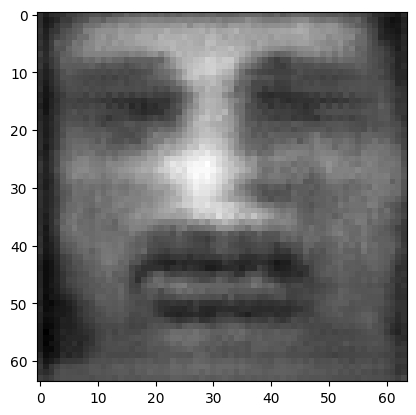

In [58]:
generated_image(5)

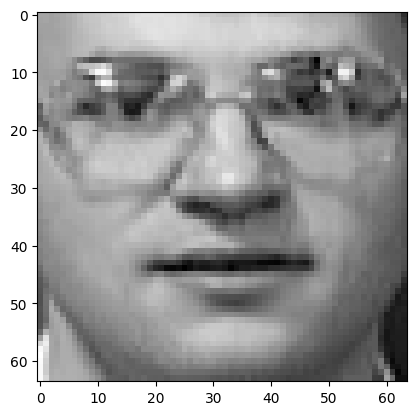

In [59]:
label_to_picture(5)

In [60]:
for i in range(10):
    evolve_generator(100, 0.001, 0.0002, 0.99, 1)
    d, l = discriminator_make_dataset()
    train_discriminator_eps(discriminator, 20, 0.001, 0.00001, d, l)

loss(generator):  9.948017883300782
loss(generator):  3.330069732666016
loss(generator):  0.8282103538513184
loss(generator):  0.44137158393859866
loss(generator):  0.088700670003891
loss(generator):  0.10301104784011841
loss(generator):  0.07723951935768128
loss(generator):  0.05451703071594238
loss(generator):  0.03626302182674408
loss(generator):  0.03770079612731934
loss(generator):  0.021029126644134522
loss(generator):  0.021489065885543824
loss(generator):  0.039882832765579225
loss(generator):  0.018783946335315705
loss(generator):  0.01987626403570175
loss(generator):  0.01631040871143341
loss(generator):  0.020341818034648896
loss(generator):  0.016408079862594606
loss(generator):  0.016845929622650146
loss(generator):  0.014369112253189088
loss(generator):  0.015990208089351653
loss(generator):  0.016509141027927398
loss(generator):  0.01396763175725937
loss(generator):  0.01242377758026123
loss(generator):  0.01567179262638092
loss(generator):  0.0131507009267807
loss(gener

400it [00:01, 350.77it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 29.306
epoch start:  1
training ...


400it [00:01, 351.09it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.380
epoch start:  2
training ...


400it [00:01, 349.17it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.224
epoch start:  3
training ...


400it [00:01, 336.42it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.162
epoch start:  4
training ...


400it [00:01, 332.88it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.124
epoch start:  5
training ...


400it [00:01, 318.62it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.100
epoch start:  6
training ...


400it [00:01, 333.20it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.084
epoch start:  7
training ...


400it [00:01, 331.36it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.072
epoch start:  8
training ...


400it [00:01, 331.70it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.063
epoch start:  9
training ...


400it [00:01, 333.05it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.056
epoch start:  10
training ...


400it [00:01, 334.69it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.050
epoch start:  11
training ...


400it [00:01, 333.21it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.046
epoch start:  12
training ...


400it [00:01, 333.81it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.042
epoch start:  13
training ...


400it [00:01, 351.15it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.038
epoch start:  14
training ...


400it [00:01, 350.67it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.035
epoch start:  15
training ...


400it [00:01, 350.77it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.033
epoch start:  16
training ...


400it [00:01, 343.39it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.031
epoch start:  17
training ...


400it [00:01, 332.95it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.029
epoch start:  18
training ...


400it [00:01, 333.18it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.027
epoch start:  19
training ...


400it [00:01, 333.06it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.026
loss(generator):  11.905741119384766
loss(generator):  4.863059616088867
loss(generator):  2.9561790466308593
loss(generator):  0.48712940216064454
loss(generator):  0.19743430614471436
loss(generator):  0.10340944528579712
loss(generator):  0.08246515989303589
loss(generator):  0.07532894015312194
loss(generator):  0.04483033120632172
loss(generator):  0.06575531959533691
loss(generator):  0.04835222065448761
loss(generator):  0.06865020990371704
loss(generator):  0.02578868567943573
loss(generator):  0.04731981754302979
loss(generator):  0.0345339834690094
loss(generator):  0.03086538314819336
loss(generator):  0.02781103253364563
loss(generator):  0.028319928050041198
loss(generator):  0.02797693610191345
loss(generator):  0.024515333771705627
loss(generator):  0.032283419370651247
loss(generator):  0.016845375299453735
loss(generator):  0.021986517310142516
loss(generator):  0.026831570267677306
loss(generator):  0.024571852385997774
loss(g

400it [00:01, 321.92it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 41.518
epoch start:  1
training ...


400it [00:01, 327.89it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.462
epoch start:  2
training ...


400it [00:01, 342.22it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.239
epoch start:  3
training ...


400it [00:01, 342.59it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.164
epoch start:  4
training ...


400it [00:01, 325.89it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.124
epoch start:  5
training ...


400it [00:01, 341.63it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.098
epoch start:  6
training ...


400it [00:01, 348.46it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.081
epoch start:  7
training ...


400it [00:01, 346.37it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.069
epoch start:  8
training ...


400it [00:01, 346.96it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.060
epoch start:  9
training ...


400it [00:01, 346.70it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.053
epoch start:  10
training ...


400it [00:01, 346.59it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.047
epoch start:  11
training ...


400it [00:01, 344.62it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.043
epoch start:  12
training ...


400it [00:01, 341.47it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.039
epoch start:  13
training ...


400it [00:01, 326.51it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.036
epoch start:  14
training ...


400it [00:01, 326.90it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.033
epoch start:  15
training ...


400it [00:01, 338.40it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.030
epoch start:  16
training ...


400it [00:01, 348.43it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.028
epoch start:  17
training ...


400it [00:01, 347.84it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.027
epoch start:  18
training ...


400it [00:01, 335.53it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.025
epoch start:  19
training ...


400it [00:01, 327.86it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.024
loss(generator):  12.310838317871093
loss(generator):  2.7362087249755858
loss(generator):  2.9256643295288085
loss(generator):  1.3895512580871583
loss(generator):  0.7125375270843506
loss(generator):  0.1428048849105835
loss(generator):  0.05492880940437317
loss(generator):  0.03887577950954437
loss(generator):  0.0569948673248291
loss(generator):  0.04474388062953949
loss(generator):  0.0410456508398056
loss(generator):  0.023924465477466583
loss(generator):  0.034182804822921756
loss(generator):  0.02039230763912201
loss(generator):  0.025820034742355346
loss(generator):  0.025106847286224365
loss(generator):  0.035508960485458374
loss(generator):  0.029005351662635803
loss(generator):  0.01649911254644394
loss(generator):  0.01816663295030594
loss(generator):  0.018113306164741515
loss(generator):  0.025339123606681824
loss(generator):  0.0252430260181427
loss(generator):  0.015627819299697875
loss(generator):  0.019767327606678008
loss(ge

400it [00:01, 330.46it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 58.635
epoch start:  1
training ...


400it [00:01, 327.02it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.010
epoch start:  2
training ...


400it [00:01, 331.46it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.475
epoch start:  3
training ...


400it [00:01, 338.98it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.301
epoch start:  4
training ...


400it [00:01, 350.48it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.219
epoch start:  5
training ...


400it [00:01, 350.13it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.170
epoch start:  6
training ...


400it [00:01, 353.19it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.139
epoch start:  7
training ...


400it [00:01, 352.99it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.116
epoch start:  8
training ...


400it [00:01, 352.74it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.100
epoch start:  9
training ...


400it [00:01, 349.52it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.087
epoch start:  10
training ...


400it [00:01, 348.06it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.077
epoch start:  11
training ...


400it [00:01, 349.74it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.069
epoch start:  12
training ...


400it [00:01, 349.64it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.062
epoch start:  13
training ...


400it [00:01, 349.34it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.057
epoch start:  14
training ...


400it [00:01, 348.50it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.052
epoch start:  15
training ...


400it [00:01, 346.47it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.048
epoch start:  16
training ...


400it [00:01, 349.14it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.045
epoch start:  17
training ...


400it [00:01, 350.06it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.042
epoch start:  18
training ...


400it [00:01, 349.89it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.039
epoch start:  19
training ...


400it [00:01, 350.36it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.037
loss(generator):  11.505193328857422
loss(generator):  2.5703277587890625
loss(generator):  1.435682487487793
loss(generator):  0.6100841999053955
loss(generator):  0.28839547634124757
loss(generator):  0.13689135313034057
loss(generator):  0.1251857876777649
loss(generator):  0.12664982080459594
loss(generator):  0.09457377195358277
loss(generator):  0.07760536670684814
loss(generator):  0.10129923820495605
loss(generator):  0.04447888433933258
loss(generator):  0.08988099098205567
loss(generator):  0.0638498067855835
loss(generator):  0.05973226428031921
loss(generator):  0.058124649524688723
loss(generator):  0.06566763520240784
loss(generator):  0.04397444427013397
loss(generator):  0.03677670955657959
loss(generator):  0.0411321222782135
loss(generator):  0.04377489387989044
loss(generator):  0.031164008378982543
loss(generator):  0.044630736112594604
loss(generator):  0.042481216788291934
loss(generator):  0.0419300526380539
loss(generato

400it [00:01, 334.34it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 33.108
epoch start:  1
training ...


400it [00:01, 332.99it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.402
epoch start:  2
training ...


400it [00:01, 334.08it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.213
epoch start:  3
training ...


400it [00:01, 349.19it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.146
epoch start:  4
training ...


400it [00:01, 352.67it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.113
epoch start:  5
training ...


400it [00:01, 345.77it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.090
epoch start:  6
training ...


400it [00:01, 355.83it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.076
epoch start:  7
training ...


400it [00:01, 367.73it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.065
epoch start:  8
training ...


400it [00:01, 334.32it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.057
epoch start:  9
training ...


400it [00:01, 333.34it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.050
epoch start:  10
training ...


400it [00:01, 349.09it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.045
epoch start:  11
training ...


400it [00:01, 337.16it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.041
epoch start:  12
training ...


400it [00:01, 345.09it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.037
epoch start:  13
training ...


400it [00:01, 351.73it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.034
epoch start:  14
training ...


400it [00:01, 352.68it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.031
epoch start:  15
training ...


400it [00:01, 353.05it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.029
epoch start:  16
training ...


400it [00:01, 353.07it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.027
epoch start:  17
training ...


400it [00:01, 352.94it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.026
epoch start:  18
training ...


400it [00:01, 349.56it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.024
epoch start:  19
training ...


400it [00:01, 343.88it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.023
loss(generator):  13.744525146484374
loss(generator):  2.4463993072509767
loss(generator):  1.0067990303039551
loss(generator):  0.35717976093292236
loss(generator):  0.16150460243225098
loss(generator):  0.07199414372444153
loss(generator):  0.03915249407291412
loss(generator):  0.028489401936531066
loss(generator):  0.017040006816387177
loss(generator):  0.0276583194732666
loss(generator):  0.027128085494041443
loss(generator):  0.017368344962596892
loss(generator):  0.021999847888946534
loss(generator):  0.025219255685806276
loss(generator):  0.013617789745330811
loss(generator):  0.016757375001907347
loss(generator):  0.01575498580932617
loss(generator):  0.011716310679912568
loss(generator):  0.012478991597890853
loss(generator):  0.019635316729545594
loss(generator):  0.01531614363193512
loss(generator):  0.013140915334224701
loss(generator):  0.012036273628473282
loss(generator):  0.010430857539176941
loss(generator):  0.0127215042710304

400it [00:01, 348.65it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 49.739
epoch start:  1
training ...


400it [00:01, 344.89it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.547
epoch start:  2
training ...


400it [00:01, 345.41it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.270
epoch start:  3
training ...


400it [00:01, 346.37it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.176
epoch start:  4
training ...


400it [00:01, 331.72it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.129
epoch start:  5
training ...


400it [00:01, 332.98it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.101
epoch start:  6
training ...


400it [00:01, 333.04it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.083
epoch start:  7
training ...


400it [00:01, 331.90it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.069
epoch start:  8
training ...


400it [00:01, 335.45it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.060
epoch start:  9
training ...


400it [00:01, 330.22it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.052
epoch start:  10
training ...


400it [00:01, 328.53it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.047
epoch start:  11
training ...


400it [00:01, 327.28it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.042
epoch start:  12
training ...


400it [00:01, 328.81it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.038
epoch start:  13
training ...


400it [00:01, 328.56it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.034
epoch start:  14
training ...


400it [00:01, 309.73it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.032
epoch start:  15
training ...


400it [00:01, 328.33it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.029
epoch start:  16
training ...


400it [00:01, 328.01it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.027
epoch start:  17
training ...


400it [00:01, 334.47it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.025
epoch start:  18
training ...


400it [00:01, 351.92it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.024
epoch start:  19
training ...


400it [00:01, 348.96it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.022
loss(generator):  11.60950927734375
loss(generator):  2.6749528884887694
loss(generator):  1.544839572906494
loss(generator):  1.0407402038574218
loss(generator):  0.26701042652130125
loss(generator):  0.1312934398651123
loss(generator):  0.1424296021461487
loss(generator):  0.08216363191604614
loss(generator):  0.08290733695030213
loss(generator):  0.05695547461509705
loss(generator):  0.06955437064170837
loss(generator):  0.05218402147293091
loss(generator):  0.06020233631134033
loss(generator):  0.042581894993782045
loss(generator):  0.07337412834167481
loss(generator):  0.056371492147445676
loss(generator):  0.04719602465629578
loss(generator):  0.04377913773059845
loss(generator):  0.0389340341091156
loss(generator):  0.0347341924905777
loss(generator):  0.03834058344364166
loss(generator):  0.03659072518348694
loss(generator):  0.028987181186676026
loss(generator):  0.03383721709251404
loss(generator):  0.028271886706352233
loss(generator

400it [00:01, 352.77it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 60.524
epoch start:  1
training ...


400it [00:01, 351.92it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.628
epoch start:  2
training ...


400it [00:01, 353.49it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.303
epoch start:  3
training ...


400it [00:01, 352.57it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.198
epoch start:  4
training ...


400it [00:01, 353.30it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.148
epoch start:  5
training ...


400it [00:01, 336.47it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.117
epoch start:  6
training ...


400it [00:01, 345.43it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.096
epoch start:  7
training ...


400it [00:01, 353.31it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.081
epoch start:  8
training ...


400it [00:01, 359.46it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.071
epoch start:  9
training ...


400it [00:01, 364.90it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.062
epoch start:  10
training ...


400it [00:01, 365.09it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.055
epoch start:  11
training ...


400it [00:01, 358.57it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.050
epoch start:  12
training ...


400it [00:01, 356.50it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.045
epoch start:  13
training ...


400it [00:01, 350.90it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.041
epoch start:  14
training ...


400it [00:01, 353.44it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.038
epoch start:  15
training ...


400it [00:01, 353.59it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.035
epoch start:  16
training ...


400it [00:01, 366.32it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.033
epoch start:  17
training ...


400it [00:01, 376.60it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.031
epoch start:  18
training ...


400it [00:01, 374.77it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.029
epoch start:  19
training ...


400it [00:01, 368.25it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.027
loss(generator):  10.270608520507812
loss(generator):  2.7035200119018556
loss(generator):  1.8176937103271484
loss(generator):  1.1446714401245117
loss(generator):  0.5593967914581299
loss(generator):  0.3397849082946777
loss(generator):  0.13780882358551025
loss(generator):  0.08880205154418945
loss(generator):  0.09297661185264587
loss(generator):  0.08582308292388915
loss(generator):  0.07162330150604249
loss(generator):  0.06743448972702026
loss(generator):  0.05712466835975647
loss(generator):  0.05476869940757752
loss(generator):  0.051586002111434937
loss(generator):  0.04814842045307159
loss(generator):  0.049025189876556394
loss(generator):  0.03784487545490265
loss(generator):  0.04064334630966186
loss(generator):  0.044758650660514834
loss(generator):  0.0330752968788147
loss(generator):  0.043652743101119995
loss(generator):  0.03332836925983429
loss(generator):  0.04171067476272583
loss(generator):  0.03615671396255493
loss(genera

400it [00:01, 347.14it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 62.818
epoch start:  1
training ...


400it [00:01, 349.18it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.734
epoch start:  2
training ...


400it [00:01, 356.32it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.338
epoch start:  3
training ...


400it [00:01, 362.07it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.218
epoch start:  4
training ...


400it [00:01, 361.07it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.160
epoch start:  5
training ...


400it [00:01, 362.14it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.125
epoch start:  6
training ...


400it [00:01, 361.85it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.102
epoch start:  7
training ...


400it [00:01, 350.97it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.086
epoch start:  8
training ...


400it [00:01, 366.78it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.074
epoch start:  9
training ...


400it [00:01, 366.84it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.065
epoch start:  10
training ...


400it [00:01, 367.40it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.057
epoch start:  11
training ...


400it [00:01, 369.77it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.052
epoch start:  12
training ...


400it [00:01, 373.80it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.047
epoch start:  13
training ...


400it [00:01, 371.85it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.043
epoch start:  14
training ...


400it [00:01, 358.01it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.039
epoch start:  15
training ...


400it [00:01, 351.36it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.036
epoch start:  16
training ...


400it [00:01, 361.48it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.034
epoch start:  17
training ...


400it [00:01, 351.63it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.032
epoch start:  18
training ...


400it [00:01, 367.32it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.029
epoch start:  19
training ...


400it [00:01, 366.28it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.028
loss(generator):  9.740373229980468
loss(generator):  2.4276269912719726
loss(generator):  0.4321280002593994
loss(generator):  0.20760180950164794
loss(generator):  0.1328458309173584
loss(generator):  0.06313275694847106
loss(generator):  0.07075790166854859
loss(generator):  0.05017695426940918
loss(generator):  0.05493780374526978
loss(generator):  0.0390074610710144
loss(generator):  0.033544376492500305
loss(generator):  0.03905566930770874
loss(generator):  0.020718911290168764
loss(generator):  0.032519271969795226
loss(generator):  0.025298359990119933
loss(generator):  0.027831381559371947
loss(generator):  0.021729467809200285
loss(generator):  0.022395659983158112
loss(generator):  0.019366277754306792
loss(generator):  0.017481833696365356
loss(generator):  0.01654035449028015
loss(generator):  0.02173219472169876
loss(generator):  0.022190918028354645
loss(generator):  0.02227848619222641
loss(generator):  0.014877748489379884
los

400it [00:01, 323.13it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 51.761
epoch start:  1
training ...


400it [00:01, 325.64it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.900
epoch start:  2
training ...


400it [00:01, 325.09it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.438
epoch start:  3
training ...


400it [00:01, 328.96it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.283
epoch start:  4
training ...


400it [00:01, 324.18it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.206
epoch start:  5
training ...


400it [00:01, 321.06it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.160
epoch start:  6
training ...


400it [00:01, 326.84it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.131
epoch start:  7
training ...


400it [00:01, 324.40it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.110
epoch start:  8
training ...


400it [00:01, 323.71it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.093
epoch start:  9
training ...


400it [00:01, 325.89it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.082
epoch start:  10
training ...


400it [00:01, 334.16it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.072
epoch start:  11
training ...


400it [00:01, 339.85it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.065
epoch start:  12
training ...


400it [00:01, 348.71it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.059
epoch start:  13
training ...


400it [00:01, 344.16it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.053
epoch start:  14
training ...


400it [00:01, 324.15it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.049
epoch start:  15
training ...


400it [00:01, 309.61it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.045
epoch start:  16
training ...


400it [00:01, 325.52it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.042
epoch start:  17
training ...


400it [00:01, 327.54it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.039
epoch start:  18
training ...


400it [00:01, 326.62it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.037
epoch start:  19
training ...


400it [00:01, 343.68it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.034
loss(generator):  11.355856323242188
loss(generator):  1.9391935348510743
loss(generator):  0.48637166023254397
loss(generator):  0.3268877506256104
loss(generator):  0.14214874505996705
loss(generator):  0.09648318290710449
loss(generator):  0.05842142105102539
loss(generator):  0.07764549255371093
loss(generator):  0.06922580003738403
loss(generator):  0.05177079439163208
loss(generator):  0.03866552412509918
loss(generator):  0.04383318424224854
loss(generator):  0.03734087347984314
loss(generator):  0.03353108167648315
loss(generator):  0.026227647066116334
loss(generator):  0.036346709728240965
loss(generator):  0.02814322113990784
loss(generator):  0.02427213191986084
loss(generator):  0.02346995770931244
loss(generator):  0.026829561591148375
loss(generator):  0.015187174081802368
loss(generator):  0.022998788952827455
loss(generator):  0.022536244988441468
loss(generator):  0.022897063195705412
loss(generator):  0.017149287462234496
los

400it [00:01, 345.44it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 85.781
epoch start:  1
training ...


400it [00:01, 343.63it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.084
epoch start:  2
training ...


400it [00:01, 347.26it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.469
epoch start:  3
training ...


400it [00:01, 345.67it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.296
epoch start:  4
training ...


400it [00:01, 329.95it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.214
epoch start:  5
training ...


400it [00:01, 335.97it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.165
epoch start:  6
training ...


400it [00:01, 347.81it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.133
epoch start:  7
training ...


400it [00:01, 328.86it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.111
epoch start:  8
training ...


400it [00:01, 309.16it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.095
epoch start:  9
training ...


400it [00:01, 348.46it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.083
epoch start:  10
training ...


400it [00:01, 343.30it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.074
epoch start:  11
training ...


400it [00:01, 331.32it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.066
epoch start:  12
training ...


400it [00:01, 333.16it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.060
epoch start:  13
training ...


400it [00:01, 337.62it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.054
epoch start:  14
training ...


400it [00:01, 347.17it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.050
epoch start:  15
training ...


400it [00:01, 346.98it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.046
epoch start:  16
training ...


400it [00:01, 347.32it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.043
epoch start:  17
training ...


400it [00:01, 346.70it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.040
epoch start:  18
training ...


400it [00:01, 344.87it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.037
epoch start:  19
training ...


400it [00:01, 346.67it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.035
loss(generator):  10.62221908569336
loss(generator):  0.788601303100586
loss(generator):  0.2349844455718994
loss(generator):  0.08899964094161987
loss(generator):  0.058885371685028075
loss(generator):  0.05989912748336792
loss(generator):  0.05893983840942383
loss(generator):  0.032999634742736816
loss(generator):  0.03888811767101288
loss(generator):  0.024728333950042723
loss(generator):  0.024415609240531922
loss(generator):  0.025703305006027223
loss(generator):  0.031476002931594846
loss(generator):  0.023290655016899107
loss(generator):  0.044772607088088986
loss(generator):  0.02212570160627365
loss(generator):  0.021151092648506165
loss(generator):  0.025792935490608217
loss(generator):  0.019360339641571044
loss(generator):  0.018275372684001923
loss(generator):  0.029894703626632692
loss(generator):  0.024620512127876283
loss(generator):  0.01889551877975464
loss(generator):  0.020396076142787933
loss(generator):  0.0238583326339721

400it [00:01, 349.96it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 34.065
epoch start:  1
training ...


400it [00:01, 337.41it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.331
epoch start:  2
training ...


400it [00:01, 352.02it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.185
epoch start:  3
training ...


400it [00:01, 353.84it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.134
epoch start:  4
training ...


400it [00:01, 354.56it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.105
epoch start:  5
training ...


400it [00:01, 354.55it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.086
epoch start:  6
training ...


400it [00:01, 326.46it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.073
epoch start:  7
training ...


400it [00:01, 301.63it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.063
epoch start:  8
training ...


400it [00:01, 333.86it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.055
epoch start:  9
training ...


400it [00:01, 340.17it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.049
epoch start:  10
training ...


400it [00:01, 337.32it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.045
epoch start:  11
training ...


400it [00:01, 330.94it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.041
epoch start:  12
training ...


400it [00:01, 329.83it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.037
epoch start:  13
training ...


400it [00:01, 329.12it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.034
epoch start:  14
training ...


400it [00:01, 331.09it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.032
epoch start:  15
training ...


400it [00:01, 343.24it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.030
epoch start:  16
training ...


400it [00:01, 348.48it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.028
epoch start:  17
training ...


400it [00:01, 348.84it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.026
epoch start:  18
training ...


400it [00:01, 348.74it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.024
epoch start:  19
training ...


400it [00:01, 352.32it/s]

Epoch: 20 | Time: 0m 1s	Train Loss: 0.023


In [79]:
for i in range(30):
    evolve_generator(20, 0.001, 0.0002, 0.99, 1)
    d, l = discriminator_make_dataset()
    train_discriminator_eps(discriminator, 10, 0.001, 0.00001, d, l)

loss(generator):  12.397869110107422
loss(generator):  4.312712097167969
loss(generator):  3.1521652221679686
loss(generator):  1.9352540969848633
loss(generator):  0.7549581527709961
loss(generator):  0.4632865428924561
loss(generator):  0.27979819774627684
loss(generator):  0.20294361114501952
loss(generator):  0.1468483328819275
loss(generator):  0.13409892320632935
loss(generator):  0.10777487754821777
loss(generator):  0.11768161058425904
loss(generator):  0.11052029132843018
loss(generator):  0.08876926302909852
loss(generator):  0.0988443911075592
loss(generator):  0.10489952564239502
loss(generator):  0.09557296633720398
loss(generator):  0.07548028230667114
loss(generator):  0.07059022784233093
loss(generator):  0.07654669284820556
epoch start:  0
training ...


400it [00:01, 306.98it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 89.018
epoch start:  1
training ...


400it [00:01, 329.15it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.974
epoch start:  2
training ...


400it [00:01, 279.81it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.336
epoch start:  3
training ...


400it [00:01, 319.99it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.212
epoch start:  4
training ...


400it [00:01, 323.85it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.155
epoch start:  5
training ...


400it [00:01, 324.00it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.120
epoch start:  6
training ...


400it [00:01, 318.15it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.098
epoch start:  7
training ...


400it [00:01, 328.44it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.082
epoch start:  8
training ...


400it [00:01, 326.92it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.071
epoch start:  9
training ...


400it [00:01, 322.85it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.062
loss(generator):  8.841442108154297
loss(generator):  2.4517412185668945
loss(generator):  1.720803451538086
loss(generator):  0.5242464065551757
loss(generator):  0.14369328022003175
loss(generator):  0.05751824378967285
loss(generator):  0.04120669364929199
loss(generator):  0.02890357971191406
loss(generator):  0.028503215312957762
loss(generator):  0.03570428490638733
loss(generator):  0.02706468403339386
loss(generator):  0.021067841351032256
loss(generator):  0.021614019572734833
loss(generator):  0.026732632517814638
loss(generator):  0.01766366809606552
loss(generator):  0.019783374667167664
loss(generator):  0.019894830882549286
loss(generator):  0.020189589262008666
loss(generator):  0.017362599074840546
loss(generator):  0.013732615113258361
epoch start:  0
training ...


400it [00:01, 298.20it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 48.682
epoch start:  1
training ...


400it [00:01, 307.61it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.222
epoch start:  2
training ...


400it [00:01, 296.50it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.496
epoch start:  3
training ...


400it [00:01, 311.16it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.307
epoch start:  4
training ...


400it [00:01, 292.49it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.221
epoch start:  5
training ...


400it [00:01, 300.91it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.171
epoch start:  6
training ...


400it [00:01, 318.74it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.139
epoch start:  7
training ...


400it [00:01, 304.89it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.116
epoch start:  8
training ...


400it [00:01, 315.30it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.100
epoch start:  9
training ...


400it [00:01, 307.95it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.087
loss(generator):  9.78834228515625
loss(generator):  3.1778188705444337
loss(generator):  0.7283242225646973
loss(generator):  0.41466670036315917
loss(generator):  0.17683672904968262
loss(generator):  0.11410582065582275
loss(generator):  0.09869930744171143
loss(generator):  0.10929723978042602
loss(generator):  0.10591518878936768
loss(generator):  0.07439188361167907
loss(generator):  0.09498446583747863
loss(generator):  0.06891459226608276
loss(generator):  0.06108576059341431
loss(generator):  0.04858557879924774
loss(generator):  0.04822891056537628
loss(generator):  0.050849950313568114
loss(generator):  0.04992672502994537
loss(generator):  0.030006110668182373
loss(generator):  0.03304542899131775
loss(generator):  0.04879308938980102
epoch start:  0
training ...


400it [00:01, 289.93it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 44.175
epoch start:  1
training ...


400it [00:01, 319.50it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.658
epoch start:  2
training ...


400it [00:01, 319.91it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.326
epoch start:  3
training ...


400it [00:01, 302.16it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.217
epoch start:  4
training ...


400it [00:01, 316.07it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.160
epoch start:  5
training ...


400it [00:01, 324.15it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.126
epoch start:  6
training ...


400it [00:01, 307.29it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.103
epoch start:  7
training ...


400it [00:01, 300.08it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.088
epoch start:  8
training ...


400it [00:01, 316.55it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.075
epoch start:  9
training ...


400it [00:01, 318.83it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.066
loss(generator):  9.680704498291016
loss(generator):  3.8361949920654297
loss(generator):  1.2809115409851075
loss(generator):  0.36087422370910643
loss(generator):  0.15166594982147216
loss(generator):  0.09539251327514649
loss(generator):  0.07756254673004151
loss(generator):  0.06432173252105713
loss(generator):  0.06347504854202271
loss(generator):  0.06176175475120545
loss(generator):  0.05514116287231445
loss(generator):  0.04400320053100586
loss(generator):  0.038728061318397525
loss(generator):  0.03062361478805542
loss(generator):  0.042684122920036316
loss(generator):  0.03843421936035156
loss(generator):  0.04043606817722321
loss(generator):  0.034807121753692626
loss(generator):  0.03469655215740204
loss(generator):  0.029406654834747314
epoch start:  0
training ...


400it [00:01, 325.16it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 55.822
epoch start:  1
training ...


400it [00:01, 317.50it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 2.088
epoch start:  2
training ...


400it [00:01, 331.08it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.570
epoch start:  3
training ...


400it [00:01, 318.94it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.323
epoch start:  4
training ...


400it [00:01, 286.73it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.225
epoch start:  5
training ...


400it [00:01, 305.76it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.173
epoch start:  6
training ...


400it [00:01, 318.35it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.141
epoch start:  7
training ...


400it [00:01, 313.68it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.116
epoch start:  8
training ...


400it [00:01, 317.24it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.100
epoch start:  9
training ...


400it [00:01, 307.91it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.087
loss(generator):  10.177368927001954
loss(generator):  2.995742607116699
loss(generator):  0.7891336917877197
loss(generator):  0.2936169862747192
loss(generator):  0.24154517650604249
loss(generator):  0.16315923929214476
loss(generator):  0.21577107906341553
loss(generator):  0.13946714401245117
loss(generator):  0.12152464389801025
loss(generator):  0.09093791842460633
loss(generator):  0.08614653944969178
loss(generator):  0.09470636248588563
loss(generator):  0.08219659924507142
loss(generator):  0.0729854941368103
loss(generator):  0.05752066969871521
loss(generator):  0.07391254305839538
loss(generator):  0.053219550848007204
loss(generator):  0.054392820596694945
loss(generator):  0.04392638206481934
loss(generator):  0.050906801223754884
epoch start:  0
training ...


400it [00:01, 286.93it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 81.694
epoch start:  1
training ...


400it [00:01, 320.90it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.924
epoch start:  2
training ...


400it [00:01, 322.36it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.454
epoch start:  3
training ...


400it [00:01, 311.36it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.293
epoch start:  4
training ...


400it [00:01, 321.07it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.213
epoch start:  5
training ...


400it [00:01, 321.42it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.167
epoch start:  6
training ...


400it [00:01, 279.25it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.136
epoch start:  7
training ...


400it [00:01, 323.22it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.115
epoch start:  8
training ...


400it [00:01, 319.82it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.099
epoch start:  9
training ...


400it [00:01, 263.47it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.086
loss(generator):  10.779232788085938
loss(generator):  1.841745948791504
loss(generator):  0.25621485710144043
loss(generator):  0.10815482139587403
loss(generator):  0.12150037288665771
loss(generator):  0.07013382911682128
loss(generator):  0.050667297840118405
loss(generator):  0.039995455741882326
loss(generator):  0.029485750198364257
loss(generator):  0.02623169720172882
loss(generator):  0.031075027585029603
loss(generator):  0.028532519936561584
loss(generator):  0.032339933514595035
loss(generator):  0.02319176644086838
loss(generator):  0.026385670900344847
loss(generator):  0.016111689805984496
loss(generator):  0.021959584951400758
loss(generator):  0.020193108916282655
loss(generator):  0.01717529445886612
loss(generator):  0.018540862202644347
epoch start:  0
training ...


400it [00:01, 283.09it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 53.958
epoch start:  1
training ...


400it [00:01, 304.56it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.292
epoch start:  2
training ...


400it [00:01, 310.68it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.620
epoch start:  3
training ...


400it [00:01, 306.79it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.401
epoch start:  4
training ...


400it [00:01, 301.67it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.290
epoch start:  5
training ...


400it [00:01, 304.20it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.225
epoch start:  6
training ...


400it [00:01, 303.78it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.183
epoch start:  7
training ...


400it [00:01, 274.08it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.153
epoch start:  8
training ...


400it [00:01, 314.23it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.131
epoch start:  9
training ...


400it [00:01, 305.74it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.114
loss(generator):  9.331845092773438
loss(generator):  1.4353976249694824
loss(generator):  0.6051843643188477
loss(generator):  0.28128502368927
loss(generator):  0.10023449659347534
loss(generator):  0.06606312990188598
loss(generator):  0.05631011724472046
loss(generator):  0.045416200160980226
loss(generator):  0.03651419281959534
loss(generator):  0.034687548875808716
loss(generator):  0.038149508833885196
loss(generator):  0.03169243633747101
loss(generator):  0.03237517178058624
loss(generator):  0.022093260288238527
loss(generator):  0.02508951723575592
loss(generator):  0.020517218112945556
loss(generator):  0.021417903900146484
loss(generator):  0.02054206281900406
loss(generator):  0.02474304735660553
loss(generator):  0.01627732366323471
epoch start:  0
training ...


400it [00:01, 319.35it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 30.387
epoch start:  1
training ...


400it [00:01, 309.20it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.562
epoch start:  2
training ...


400it [00:01, 313.80it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.284
epoch start:  3
training ...


400it [00:01, 307.81it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.194
epoch start:  4
training ...


400it [00:01, 301.47it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.146
epoch start:  5
training ...


400it [00:01, 299.91it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.117
epoch start:  6
training ...


400it [00:01, 287.78it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.097
epoch start:  7
training ...


400it [00:01, 312.76it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.083
epoch start:  8
training ...


400it [00:01, 315.78it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.072
epoch start:  9
training ...


400it [00:01, 309.89it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.064
loss(generator):  10.803592681884766
loss(generator):  2.2726161956787108
loss(generator):  0.8071927070617676
loss(generator):  0.3649508237838745
loss(generator):  0.1942051887512207
loss(generator):  0.1344326138496399
loss(generator):  0.10175262689590454
loss(generator):  0.08272203803062439
loss(generator):  0.08845223188400268
loss(generator):  0.10488808155059814
loss(generator):  0.0555438756942749
loss(generator):  0.06868972778320312
loss(generator):  0.0562134325504303
loss(generator):  0.06399310231208802
loss(generator):  0.07176997661590576
loss(generator):  0.059608864784240725
loss(generator):  0.044426214694976804
loss(generator):  0.04202762246131897
loss(generator):  0.04135765731334686
loss(generator):  0.027538803219795228
epoch start:  0
training ...


400it [00:01, 291.61it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 17.997
epoch start:  1
training ...


400it [00:01, 322.30it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.454
epoch start:  2
training ...


400it [00:01, 331.62it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.227
epoch start:  3
training ...


400it [00:01, 328.21it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.162
epoch start:  4
training ...


400it [00:01, 316.47it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.125
epoch start:  5
training ...


400it [00:01, 283.05it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.102
epoch start:  6
training ...


400it [00:01, 308.90it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.085
epoch start:  7
training ...


400it [00:01, 293.50it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.073
epoch start:  8
training ...


400it [00:01, 328.22it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.064
epoch start:  9
training ...


400it [00:01, 332.85it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.057
loss(generator):  9.464608764648437
loss(generator):  3.1868431091308596
loss(generator):  0.8070184707641601
loss(generator):  0.5808145046234131
loss(generator):  0.32993378639221194
loss(generator):  0.1694730758666992
loss(generator):  0.12739526033401488
loss(generator):  0.13475011587142943
loss(generator):  0.08420838117599487
loss(generator):  0.08117872476577759
loss(generator):  0.06434018611907959
loss(generator):  0.06256070733070374
loss(generator):  0.056444376707077026
loss(generator):  0.03844915628433228
loss(generator):  0.0616795539855957
loss(generator):  0.05452706813812256
loss(generator):  0.03089212775230408
loss(generator):  0.040900114178657535
loss(generator):  0.04118206202983856
loss(generator):  0.03050149083137512
epoch start:  0
training ...


400it [00:01, 295.44it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 51.975
epoch start:  1
training ...


400it [00:01, 318.14it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.686
epoch start:  2
training ...


400it [00:01, 318.78it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.354
epoch start:  3
training ...


400it [00:01, 313.17it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.240
epoch start:  4
training ...


400it [00:01, 331.46it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.178
epoch start:  5
training ...


400it [00:01, 298.85it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.140
epoch start:  6
training ...


400it [00:01, 320.63it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.116
epoch start:  7
training ...


400it [00:01, 318.84it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.098
epoch start:  8
training ...


400it [00:01, 314.47it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.084
epoch start:  9
training ...


400it [00:01, 298.69it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.074
loss(generator):  9.111892700195312
loss(generator):  2.7133649826049804
loss(generator):  0.860621452331543
loss(generator):  0.3055394411087036
loss(generator):  0.13214485645294188
loss(generator):  0.10377203226089478
loss(generator):  0.08303110599517823
loss(generator):  0.0648986279964447
loss(generator):  0.054757893085479736
loss(generator):  0.0433665931224823
loss(generator):  0.04580374360084534
loss(generator):  0.05801800489425659
loss(generator):  0.032884806394577026
loss(generator):  0.03600261509418488
loss(generator):  0.034230774641036986
loss(generator):  0.030087596178054808
loss(generator):  0.031012716889381408
loss(generator):  0.02520439922809601
loss(generator):  0.051090586185455325
loss(generator):  0.0220599040389061
epoch start:  0
training ...


400it [00:01, 303.08it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 20.838
epoch start:  1
training ...


400it [00:01, 321.84it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.355
epoch start:  2
training ...


400it [00:01, 324.80it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.163
epoch start:  3
training ...


400it [00:01, 328.64it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.116
epoch start:  4
training ...


400it [00:01, 306.27it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.091
epoch start:  5
training ...


400it [00:01, 319.97it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.074
epoch start:  6
training ...


400it [00:01, 311.17it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.063
epoch start:  7
training ...


400it [00:01, 318.74it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.055
epoch start:  8
training ...


400it [00:01, 317.18it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.048
epoch start:  9
training ...


400it [00:01, 294.94it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.043
loss(generator):  10.932262420654297
loss(generator):  2.028961944580078
loss(generator):  0.5812665462493897
loss(generator):  0.1907666802406311
loss(generator):  0.07763938307762146
loss(generator):  0.07495456337928771
loss(generator):  0.0796770453453064
loss(generator):  0.0575663685798645
loss(generator):  0.05272212028503418
loss(generator):  0.06526126861572265
loss(generator):  0.045228174328804015
loss(generator):  0.04055460095405579
loss(generator):  0.042917704582214354
loss(generator):  0.0417265921831131
loss(generator):  0.0336996853351593
loss(generator):  0.031963735818862915
loss(generator):  0.03417738676071167
loss(generator):  0.04649539291858673
loss(generator):  0.028325659036636353
loss(generator):  0.02750219702720642
epoch start:  0
training ...


400it [00:01, 301.92it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 38.745
epoch start:  1
training ...


400it [00:01, 311.99it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.511
epoch start:  2
training ...


400it [00:01, 303.25it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.210
epoch start:  3
training ...


400it [00:01, 313.94it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.148
epoch start:  4
training ...


400it [00:01, 314.58it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.115
epoch start:  5
training ...


400it [00:01, 320.65it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.093
epoch start:  6
training ...


400it [00:01, 317.78it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.079
epoch start:  7
training ...


400it [00:01, 304.45it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.068
epoch start:  8
training ...


400it [00:01, 309.94it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.059
epoch start:  9
training ...


400it [00:01, 307.71it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.053
loss(generator):  10.700328063964843
loss(generator):  2.73211669921875
loss(generator):  0.8318493843078614
loss(generator):  0.7492116928100586
loss(generator):  0.40622901916503906
loss(generator):  0.2920760869979858
loss(generator):  0.09238162040710449
loss(generator):  0.07421025037765502
loss(generator):  0.061905020475387575
loss(generator):  0.07410822510719299
loss(generator):  0.03834981620311737
loss(generator):  0.05598384141921997
loss(generator):  0.0486684113740921
loss(generator):  0.03377813100814819
loss(generator):  0.03314107358455658
loss(generator):  0.04701197445392609
loss(generator):  0.024380066990852357
loss(generator):  0.034500730037689206
loss(generator):  0.028105023503303527
loss(generator):  0.0333236962556839
epoch start:  0
training ...


400it [00:01, 289.01it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 38.851
epoch start:  1
training ...


400it [00:01, 308.18it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.535
epoch start:  2
training ...


400it [00:01, 314.86it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.181
epoch start:  3
training ...


400it [00:01, 306.06it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.122
epoch start:  4
training ...


400it [00:01, 301.13it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.093
epoch start:  5
training ...


400it [00:01, 309.38it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.076
epoch start:  6
training ...


400it [00:01, 292.00it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.064
epoch start:  7
training ...


400it [00:01, 310.59it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.055
epoch start:  8
training ...


400it [00:01, 301.18it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.048
epoch start:  9
training ...


400it [00:01, 285.55it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.043
loss(generator):  11.240058898925781
loss(generator):  1.0745091438293457
loss(generator):  0.3120292901992798
loss(generator):  0.12563776969909668
loss(generator):  0.08852488994598388
loss(generator):  0.07999182939529419
loss(generator):  0.058481919765472415
loss(generator):  0.04280218183994293
loss(generator):  0.041774600744247437
loss(generator):  0.03537098467350006
loss(generator):  0.03868856132030487
loss(generator):  0.03166714310646057
loss(generator):  0.03716983795166016
loss(generator):  0.03358662128448486
loss(generator):  0.04050322473049164
loss(generator):  0.037198567390441896
loss(generator):  0.029498690366744997
loss(generator):  0.02197922468185425
loss(generator):  0.025553998351097108
loss(generator):  0.02284780889749527
epoch start:  0
training ...


400it [00:01, 323.72it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 32.183
epoch start:  1
training ...


400it [00:01, 326.07it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.712
epoch start:  2
training ...


400it [00:01, 316.30it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.394
epoch start:  3
training ...


400it [00:01, 335.65it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.267
epoch start:  4
training ...


400it [00:01, 320.69it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.200
epoch start:  5
training ...


400it [00:01, 333.50it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.158
epoch start:  6
training ...


400it [00:01, 278.85it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.130
epoch start:  7
training ...


400it [00:01, 327.56it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.110
epoch start:  8
training ...


400it [00:01, 291.21it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.095
epoch start:  9
training ...


400it [00:01, 324.41it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.083
loss(generator):  8.969143676757813
loss(generator):  2.6023908615112306
loss(generator):  1.4249209403991698
loss(generator):  0.9390764236450195
loss(generator):  0.5578696250915527
loss(generator):  0.22943563461303712
loss(generator):  0.13875560760498046
loss(generator):  0.10172489881515503
loss(generator):  0.07206709980964661
loss(generator):  0.06080719232559204
loss(generator):  0.05161327123641968
loss(generator):  0.04399780333042145
loss(generator):  0.060649949312210086
loss(generator):  0.03498716950416565
loss(generator):  0.045159456133842465
loss(generator):  0.03405032455921173
loss(generator):  0.03062072992324829
loss(generator):  0.02703326940536499
loss(generator):  0.06386729478836059
loss(generator):  0.02708947956562042
epoch start:  0
training ...


400it [00:01, 315.13it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 43.147
epoch start:  1
training ...


400it [00:01, 320.32it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.431
epoch start:  2
training ...


400it [00:01, 320.53it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.146
epoch start:  3
training ...


400it [00:01, 322.71it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.106
epoch start:  4
training ...


400it [00:01, 317.47it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.085
epoch start:  5
training ...


400it [00:01, 327.57it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.071
epoch start:  6
training ...


400it [00:01, 318.41it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.062
epoch start:  7
training ...


400it [00:01, 312.24it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.055
epoch start:  8
training ...


400it [00:01, 327.93it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.049
epoch start:  9
training ...


400it [00:01, 325.86it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.044
loss(generator):  10.044499969482422
loss(generator):  2.8347345352172852
loss(generator):  0.8648767471313477
loss(generator):  0.2985256195068359
loss(generator):  0.23318710327148437
loss(generator):  0.2253506898880005
loss(generator):  0.16462794542312623
loss(generator):  0.10576071739196777
loss(generator):  0.13320770263671874
loss(generator):  0.10162400007247925
loss(generator):  0.08294228315353394
loss(generator):  0.06909080147743225
loss(generator):  0.06320815682411193
loss(generator):  0.06367648839950561
loss(generator):  0.049536782503128055
loss(generator):  0.06210463047027588
loss(generator):  0.04626825153827667
loss(generator):  0.049443173408508304
loss(generator):  0.03426634669303894
loss(generator):  0.04378705322742462
epoch start:  0
training ...


400it [00:01, 258.92it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 26.006
epoch start:  1
training ...


400it [00:01, 307.89it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.308
epoch start:  2
training ...


400it [00:01, 289.25it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.198
epoch start:  3
training ...


400it [00:01, 292.80it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.147
epoch start:  4
training ...


400it [00:01, 305.35it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.117
epoch start:  5
training ...


400it [00:01, 313.96it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.097
epoch start:  6
training ...


400it [00:01, 282.19it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.082
epoch start:  7
training ...


400it [00:01, 304.67it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.072
epoch start:  8
training ...


400it [00:01, 276.72it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.063
epoch start:  9
training ...


400it [00:01, 302.19it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.057
loss(generator):  9.969689178466798
loss(generator):  2.282772254943848
loss(generator):  0.9878753662109375
loss(generator):  0.9910240173339844
loss(generator):  0.1383801817893982
loss(generator):  0.1499832272529602
loss(generator):  0.05323303937911987
loss(generator):  0.05764227509498596
loss(generator):  0.07703022956848145
loss(generator):  0.06771101355552674
loss(generator):  0.03510653376579285
loss(generator):  0.04191024899482727
loss(generator):  0.03474870622158051
loss(generator):  0.03889861404895782
loss(generator):  0.028655686974525453
loss(generator):  0.025079840421676637
loss(generator):  0.02272861301898956
loss(generator):  0.03252831399440766
loss(generator):  0.02049889862537384
loss(generator):  0.025648880004882812
epoch start:  0
training ...


400it [00:01, 304.26it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 44.802
epoch start:  1
training ...


400it [00:01, 270.66it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.705
epoch start:  2
training ...


400it [00:01, 298.03it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.289
epoch start:  3
training ...


400it [00:01, 305.79it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.208
epoch start:  4
training ...


400it [00:01, 318.37it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.162
epoch start:  5
training ...


400it [00:01, 297.16it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.132
epoch start:  6
training ...


400it [00:01, 305.72it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.111
epoch start:  7
training ...


400it [00:01, 305.48it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.096
epoch start:  8
training ...


400it [00:01, 303.41it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.084
epoch start:  9
training ...


400it [00:01, 293.72it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.074
loss(generator):  9.987677764892577
loss(generator):  3.4443336486816407
loss(generator):  1.2120264053344727
loss(generator):  0.7380971431732177
loss(generator):  0.40735511779785155
loss(generator):  0.2746948480606079
loss(generator):  0.16863338947296141
loss(generator):  0.156366229057312
loss(generator):  0.1848006248474121
loss(generator):  0.11800034046173095
loss(generator):  0.10394896268844604
loss(generator):  0.08513146638870239
loss(generator):  0.08240048289299011
loss(generator):  0.07848978638648987
loss(generator):  0.0874794065952301
loss(generator):  0.08448612689971924
loss(generator):  0.071133953332901
loss(generator):  0.070448237657547
loss(generator):  0.06273950934410095
loss(generator):  0.05041396021842957
epoch start:  0
training ...


400it [00:01, 312.34it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 22.819
epoch start:  1
training ...


400it [00:01, 317.22it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.422
epoch start:  2
training ...


400it [00:01, 307.75it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.202
epoch start:  3
training ...


400it [00:01, 305.77it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.150
epoch start:  4
training ...


400it [00:01, 317.24it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.115
epoch start:  5
training ...


400it [00:01, 305.98it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.094
epoch start:  6
training ...


400it [00:01, 314.25it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.079
epoch start:  7
training ...


400it [00:01, 309.64it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.069
epoch start:  8
training ...


400it [00:01, 311.88it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.060
epoch start:  9
training ...


400it [00:01, 302.72it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.054
loss(generator):  9.205813598632812
loss(generator):  3.0796539306640627
loss(generator):  1.5931900024414063
loss(generator):  1.6939130783081056
loss(generator):  0.5169415473937988
loss(generator):  0.4002534866333008
loss(generator):  0.2532156229019165
loss(generator):  0.2662133455276489
loss(generator):  0.2387991189956665
loss(generator):  0.17716777324676514
loss(generator):  0.1692461133003235
loss(generator):  0.18410264253616332
loss(generator):  0.12310068607330323
loss(generator):  0.1145087718963623
loss(generator):  0.11656274795532226
loss(generator):  0.1050567626953125
loss(generator):  0.09575666785240174
loss(generator):  0.08596563339233398
loss(generator):  0.07116691470146179
loss(generator):  0.0794182300567627
epoch start:  0
training ...


400it [00:01, 313.93it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 53.864
epoch start:  1
training ...


400it [00:01, 311.64it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.794
epoch start:  2
training ...


400it [00:01, 316.37it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.328
epoch start:  3
training ...


400it [00:01, 316.43it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.218
epoch start:  4
training ...


400it [00:01, 312.77it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.163
epoch start:  5
training ...


400it [00:01, 320.51it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.130
epoch start:  6
training ...


400it [00:01, 315.87it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.108
epoch start:  7
training ...


400it [00:01, 307.87it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.092
epoch start:  8
training ...


400it [00:01, 296.89it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.080
epoch start:  9
training ...


400it [00:01, 324.16it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.071
loss(generator):  10.01098175048828
loss(generator):  2.4957677841186525
loss(generator):  1.1419055938720704
loss(generator):  0.4985332489013672
loss(generator):  0.28638501167297364
loss(generator):  0.23957414627075196
loss(generator):  0.20371897220611573
loss(generator):  0.14688761234283448
loss(generator):  0.13215550184249877
loss(generator):  0.1439015507698059
loss(generator):  0.10010157823562622
loss(generator):  0.10882068872451782
loss(generator):  0.084110426902771
loss(generator):  0.08537008166313172
loss(generator):  0.07180343270301819
loss(generator):  0.06726523637771606
loss(generator):  0.07000072598457337
loss(generator):  0.06574149131774902
loss(generator):  0.07037568092346191
loss(generator):  0.05655650496482849
epoch start:  0
training ...


400it [00:01, 281.90it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 34.292
epoch start:  1
training ...


400it [00:01, 316.06it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.796
epoch start:  2
training ...


400it [00:01, 311.26it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.409
epoch start:  3
training ...


400it [00:01, 309.40it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.272
epoch start:  4
training ...


400it [00:01, 304.57it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.202
epoch start:  5
training ...


400it [00:01, 305.61it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.160
epoch start:  6
training ...


400it [00:01, 288.22it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.132
epoch start:  7
training ...


400it [00:01, 280.20it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.112
epoch start:  8
training ...


400it [00:01, 278.57it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.098
epoch start:  9
training ...


400it [00:01, 279.98it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.085
loss(generator):  9.447895812988282
loss(generator):  3.2377681732177734
loss(generator):  2.151048469543457
loss(generator):  1.1940725326538086
loss(generator):  0.7204430580139161
loss(generator):  0.5831413745880127
loss(generator):  0.258373498916626
loss(generator):  0.15316412448883057
loss(generator):  0.1446756362915039
loss(generator):  0.09907249212265015
loss(generator):  0.09275757670402526
loss(generator):  0.07839404940605163
loss(generator):  0.07616742253303528
loss(generator):  0.08438011407852172
loss(generator):  0.05959503054618835
loss(generator):  0.06747704148292541
loss(generator):  0.06287668943405152
loss(generator):  0.06338337063789368
loss(generator):  0.04778492152690887
loss(generator):  0.046455678343772885
epoch start:  0
training ...


400it [00:01, 299.45it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 25.231
epoch start:  1
training ...


400it [00:01, 319.52it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.741
epoch start:  2
training ...


400it [00:01, 317.87it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.342
epoch start:  3
training ...


400it [00:01, 316.68it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.228
epoch start:  4
training ...


400it [00:01, 301.60it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.170
epoch start:  5
training ...


400it [00:01, 308.69it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.135
epoch start:  6
training ...


400it [00:01, 318.15it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.113
epoch start:  7
training ...


400it [00:01, 299.55it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.096
epoch start:  8
training ...


400it [00:01, 266.60it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.083
epoch start:  9
training ...


400it [00:01, 321.84it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.074
loss(generator):  9.083061981201173
loss(generator):  3.5949501037597655
loss(generator):  1.5362071990966797
loss(generator):  1.2920943260192872
loss(generator):  1.0214889526367188
loss(generator):  0.4476170539855957
loss(generator):  0.22694864273071289
loss(generator):  0.1421515703201294
loss(generator):  0.08915069103240966
loss(generator):  0.08410392999649048
loss(generator):  0.06667273044586182
loss(generator):  0.07231132984161377
loss(generator):  0.05675038695335388
loss(generator):  0.0568255364894867
loss(generator):  0.04574705362319946
loss(generator):  0.045721051096916196
loss(generator):  0.04290863573551178
loss(generator):  0.0462710052728653
loss(generator):  0.03994697034358978
loss(generator):  0.03322823941707611
epoch start:  0
training ...


400it [00:01, 307.98it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 18.936
epoch start:  1
training ...


400it [00:01, 315.44it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.499
epoch start:  2
training ...


400it [00:01, 316.62it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.191
epoch start:  3
training ...


400it [00:01, 279.44it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.126
epoch start:  4
training ...


400it [00:01, 319.57it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.098
epoch start:  5
training ...


400it [00:01, 324.88it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.080
epoch start:  6
training ...


400it [00:01, 320.59it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.068
epoch start:  7
training ...


400it [00:01, 294.25it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.059
epoch start:  8
training ...


400it [00:01, 317.75it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.052
epoch start:  9
training ...


400it [00:01, 315.85it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.047
loss(generator):  10.172409820556641
loss(generator):  4.518401336669922
loss(generator):  2.4523448944091797
loss(generator):  1.4921137809753418
loss(generator):  0.6477651596069336
loss(generator):  0.27869248390197754
loss(generator):  0.32572140693664553
loss(generator):  0.11034548282623291
loss(generator):  0.10558997392654419
loss(generator):  0.08765562772750854
loss(generator):  0.08641363978385926
loss(generator):  0.06595444679260254
loss(generator):  0.07701985239982605
loss(generator):  0.053754997253417966
loss(generator):  0.06462644338607788
loss(generator):  0.056355375051498416
loss(generator):  0.05670628547668457
loss(generator):  0.04702868461608887
loss(generator):  0.039457425475120544
loss(generator):  0.04965733289718628
epoch start:  0
training ...


400it [00:01, 312.44it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 50.917
epoch start:  1
training ...


400it [00:01, 297.75it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.213
epoch start:  2
training ...


400it [00:01, 312.46it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.365
epoch start:  3
training ...


400it [00:01, 317.51it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.236
epoch start:  4
training ...


400it [00:01, 305.89it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.175
epoch start:  5
training ...


400it [00:01, 295.88it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.138
epoch start:  6
training ...


400it [00:01, 308.12it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.114
epoch start:  7
training ...


400it [00:01, 310.52it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.097
epoch start:  8
training ...


400it [00:01, 316.83it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.083
epoch start:  9
training ...


400it [00:01, 282.04it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.073
loss(generator):  9.152335357666015
loss(generator):  2.7324153900146486
loss(generator):  0.8644214630126953
loss(generator):  0.37335526943206787
loss(generator):  0.6546594142913819
loss(generator):  0.1902994394302368
loss(generator):  0.2759140968322754
loss(generator):  0.12445940971374511
loss(generator):  0.11798648834228516
loss(generator):  0.06503729224205017
loss(generator):  0.0543235182762146
loss(generator):  0.04727561473846435
loss(generator):  0.03803212344646454
loss(generator):  0.03823179304599762
loss(generator):  0.039399319887161256
loss(generator):  0.03710587620735169
loss(generator):  0.03456854522228241
loss(generator):  0.035745462775230406
loss(generator):  0.035019335150718686
loss(generator):  0.032015302777290346
epoch start:  0
training ...


400it [00:01, 309.71it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 34.898
epoch start:  1
training ...


400it [00:01, 328.03it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.627
epoch start:  2
training ...


400it [00:01, 328.70it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.353
epoch start:  3
training ...


400it [00:01, 328.23it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.247
epoch start:  4
training ...


400it [00:01, 317.13it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.187
epoch start:  5
training ...


400it [00:01, 332.45it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.151
epoch start:  6
training ...


400it [00:01, 331.29it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.126
epoch start:  7
training ...


400it [00:01, 313.64it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.107
epoch start:  8
training ...


400it [00:01, 324.15it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.093
epoch start:  9
training ...


400it [00:01, 332.86it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.082
loss(generator):  9.646499633789062
loss(generator):  3.120584487915039
loss(generator):  0.9421747207641602
loss(generator):  0.5280781745910644
loss(generator):  0.3047023296356201
loss(generator):  0.24799709320068358
loss(generator):  0.17864623069763183
loss(generator):  0.13759164810180663
loss(generator):  0.13578580617904662
loss(generator):  0.11278343200683594
loss(generator):  0.09757829904556274
loss(generator):  0.08262592554092407
loss(generator):  0.06899481415748596
loss(generator):  0.06247410774230957
loss(generator):  0.069218909740448
loss(generator):  0.05474401712417602
loss(generator):  0.08490315675735474
loss(generator):  0.045986753702163694
loss(generator):  0.05093088746070862
loss(generator):  0.04019239246845245
epoch start:  0
training ...


400it [00:01, 322.08it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 45.634
epoch start:  1
training ...


400it [00:01, 329.66it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.489
epoch start:  2
training ...


400it [00:01, 337.14it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.273
epoch start:  3
training ...


400it [00:01, 334.73it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.191
epoch start:  4
training ...


400it [00:01, 325.73it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.146
epoch start:  5
training ...


400it [00:01, 320.81it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.118
epoch start:  6
training ...


400it [00:01, 325.34it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.099
epoch start:  7
training ...


400it [00:01, 322.30it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.085
epoch start:  8
training ...


400it [00:01, 323.20it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.074
epoch start:  9
training ...


400it [00:01, 325.48it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.065
loss(generator):  8.93382568359375
loss(generator):  3.499012756347656
loss(generator):  1.708089828491211
loss(generator):  0.5962709426879883
loss(generator):  0.4893517971038818
loss(generator):  0.37725510597229006
loss(generator):  0.20696985721588135
loss(generator):  0.05601942539215088
loss(generator):  0.03293071687221527
loss(generator):  0.044586294889450075
loss(generator):  0.04135065972805023
loss(generator):  0.039125528931617734
loss(generator):  0.031360435485839847
loss(generator):  0.03509944081306458
loss(generator):  0.03181595206260681
loss(generator):  0.024027496576309204
loss(generator):  0.02392297238111496
loss(generator):  0.020516741275787353
loss(generator):  0.03725091814994812
loss(generator):  0.026880493760108946
epoch start:  0
training ...


400it [00:01, 314.40it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 34.092
epoch start:  1
training ...


400it [00:01, 322.82it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.422
epoch start:  2
training ...


400it [00:01, 316.07it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.242
epoch start:  3
training ...


400it [00:01, 297.35it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.173
epoch start:  4
training ...


400it [00:01, 316.26it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.134
epoch start:  5
training ...


400it [00:01, 309.87it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.110
epoch start:  6
training ...


400it [00:01, 314.13it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.093
epoch start:  7
training ...


400it [00:01, 307.61it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.081
epoch start:  8
training ...


400it [00:01, 313.47it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.071
epoch start:  9
training ...


400it [00:01, 308.50it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.064
loss(generator):  11.56662826538086
loss(generator):  3.0393436431884764
loss(generator):  0.9429538726806641
loss(generator):  0.37224817276000977
loss(generator):  0.24387497901916505
loss(generator):  0.21585006713867189
loss(generator):  0.18050168752670287
loss(generator):  0.19475675821304322
loss(generator):  0.10348693132400513
loss(generator):  0.07552806735038757
loss(generator):  0.08793146014213563
loss(generator):  0.078983473777771
loss(generator):  0.06814264059066773
loss(generator):  0.08312039375305176
loss(generator):  0.05792192220687866
loss(generator):  0.05288102626800537
loss(generator):  0.046447092294692995
loss(generator):  0.05498313307762146
loss(generator):  0.04770849645137787
loss(generator):  0.03949393332004547
epoch start:  0
training ...


400it [00:01, 316.27it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 26.651
epoch start:  1
training ...


400it [00:01, 321.73it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.720
epoch start:  2
training ...


400it [00:01, 321.56it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.375
epoch start:  3
training ...


400it [00:01, 339.96it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.260
epoch start:  4
training ...


400it [00:01, 335.76it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.202
epoch start:  5
training ...


400it [00:01, 325.70it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.163
epoch start:  6
training ...


400it [00:01, 323.91it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.136
epoch start:  7
training ...


400it [00:01, 334.71it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.117
epoch start:  8
training ...


400it [00:01, 332.46it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.103
epoch start:  9
training ...


400it [00:01, 329.77it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.091
loss(generator):  8.844901275634765
loss(generator):  3.912461853027344
loss(generator):  2.2314533233642577
loss(generator):  1.8456241607666015
loss(generator):  0.7176291465759277
loss(generator):  0.5319546222686767
loss(generator):  0.4174741268157959
loss(generator):  0.3170351266860962
loss(generator):  0.2011957883834839
loss(generator):  0.13552767038345337
loss(generator):  0.14126784801483155
loss(generator):  0.13797357082366943
loss(generator):  0.10462566614151
loss(generator):  0.10462387800216674
loss(generator):  0.07633499503135681
loss(generator):  0.07085276842117309
loss(generator):  0.05964377522468567
loss(generator):  0.061110734939575195
loss(generator):  0.05304025411605835
loss(generator):  0.059202063083648684
epoch start:  0
training ...


400it [00:01, 318.94it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 34.502
epoch start:  1
training ...


400it [00:01, 318.75it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.394
epoch start:  2
training ...


400it [00:01, 308.49it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.250
epoch start:  3
training ...


400it [00:01, 315.25it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.180
epoch start:  4
training ...


400it [00:01, 320.69it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.142
epoch start:  5
training ...


400it [00:01, 319.88it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.117
epoch start:  6
training ...


400it [00:01, 315.55it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.099
epoch start:  7
training ...


400it [00:01, 257.88it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.085
epoch start:  8
training ...


400it [00:01, 314.56it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.075
epoch start:  9
training ...


400it [00:01, 317.94it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.067
loss(generator):  9.100635528564453
loss(generator):  2.9094409942626953
loss(generator):  1.7975704193115234
loss(generator):  0.9212249755859375
loss(generator):  0.6322426795959473
loss(generator):  0.3729560375213623
loss(generator):  0.2874372720718384
loss(generator):  0.20267901420593262
loss(generator):  0.1506121873855591
loss(generator):  0.10969663858413696
loss(generator):  0.11313345432281494
loss(generator):  0.10814406871795654
loss(generator):  0.0812726378440857
loss(generator):  0.09016077518463135
loss(generator):  0.0648066520690918
loss(generator):  0.054144513607025144
loss(generator):  0.04643310010433197
loss(generator):  0.05145870447158814
loss(generator):  0.04683510065078735
loss(generator):  0.052845895290374756
epoch start:  0
training ...


400it [00:01, 319.42it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 22.396
epoch start:  1
training ...


400it [00:01, 294.40it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.391
epoch start:  2
training ...


400it [00:01, 327.06it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.238
epoch start:  3
training ...


400it [00:01, 317.97it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.176
epoch start:  4
training ...


400it [00:01, 325.82it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.138
epoch start:  5
training ...


400it [00:01, 301.47it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.114
epoch start:  6
training ...


400it [00:01, 315.02it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.097
epoch start:  7
training ...


400it [00:01, 303.54it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.084
epoch start:  8
training ...


400it [00:01, 319.48it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.074
epoch start:  9
training ...


400it [00:01, 316.63it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.066
loss(generator):  10.103595733642578
loss(generator):  8.157743072509765
loss(generator):  6.567124938964843
loss(generator):  2.2070518493652345
loss(generator):  1.2483522415161132
loss(generator):  1.0723136901855468
loss(generator):  0.4743091583251953
loss(generator):  0.606739854812622
loss(generator):  0.15122945308685304
loss(generator):  0.10454814434051514
loss(generator):  0.08517423272132874
loss(generator):  0.07932584881782531
loss(generator):  0.07027525901794433
loss(generator):  0.06287276148796081
loss(generator):  0.05988417267799377
loss(generator):  0.06343005895614624
loss(generator):  0.06080452799797058
loss(generator):  0.05338822603225708
loss(generator):  0.04614311456680298
loss(generator):  0.046548157930374146
epoch start:  0
training ...


400it [00:01, 326.07it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 60.040
epoch start:  1
training ...


400it [00:01, 329.52it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.889
epoch start:  2
training ...


400it [00:01, 341.76it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.408
epoch start:  3
training ...


400it [00:01, 326.31it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.272
epoch start:  4
training ...


400it [00:01, 336.72it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.204
epoch start:  5
training ...


400it [00:01, 329.44it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.163
epoch start:  6
training ...


400it [00:01, 336.48it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.135
epoch start:  7
training ...


400it [00:01, 331.85it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.115
epoch start:  8
training ...


400it [00:01, 329.86it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.100
epoch start:  9
training ...


400it [00:01, 325.45it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.088
loss(generator):  8.38490982055664
loss(generator):  2.5667293548583983
loss(generator):  1.2667217254638672
loss(generator):  1.730206298828125
loss(generator):  1.756674575805664
loss(generator):  0.6720924854278565
loss(generator):  0.3947540521621704
loss(generator):  0.36748743057250977
loss(generator):  0.1287502884864807
loss(generator):  0.0941942036151886
loss(generator):  0.08517943024635315
loss(generator):  0.07740972042083741
loss(generator):  0.07108297944068909
loss(generator):  0.06970932483673095
loss(generator):  0.058758330345153806
loss(generator):  0.05355585217475891
loss(generator):  0.051917809247970584
loss(generator):  0.05139839053153992
loss(generator):  0.05203712582588196
loss(generator):  0.051144540309906006
epoch start:  0
training ...


400it [00:01, 313.96it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 36.278
epoch start:  1
training ...


400it [00:01, 266.33it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 0.383
epoch start:  2
training ...


400it [00:01, 249.82it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.243
epoch start:  3
training ...


400it [00:01, 314.45it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.179
epoch start:  4
training ...


400it [00:01, 306.14it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.141
epoch start:  5
training ...


400it [00:01, 307.72it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.117
epoch start:  6
training ...


400it [00:01, 232.11it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.099
epoch start:  7
training ...


400it [00:01, 267.84it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.085
epoch start:  8
training ...


400it [00:01, 318.49it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.075
epoch start:  9
training ...


400it [00:01, 308.24it/s]

Epoch: 10 | Time: 0m 1s	Train Loss: 0.067


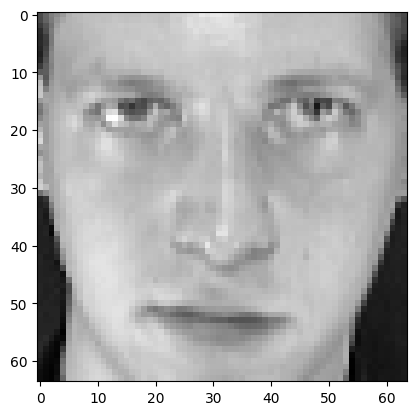

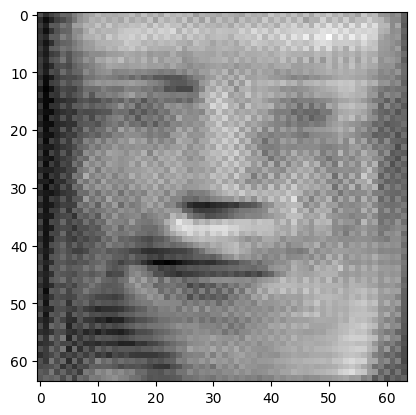

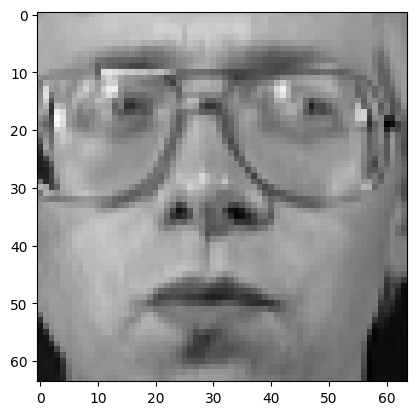

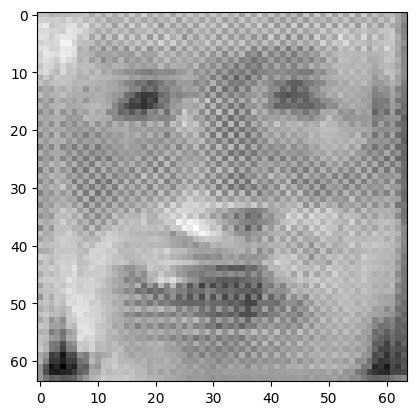

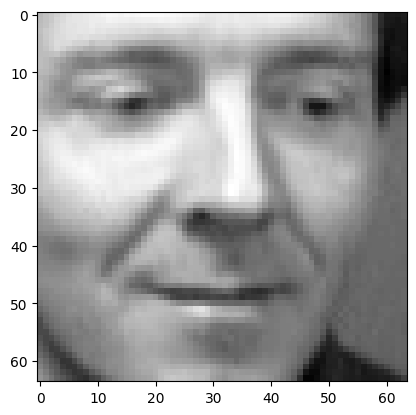

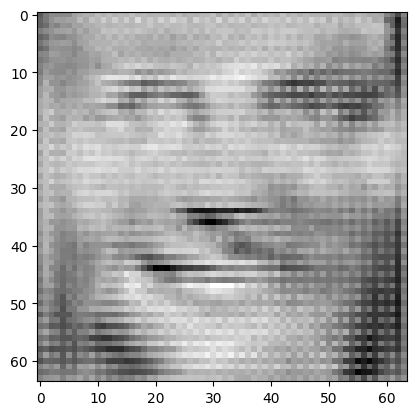

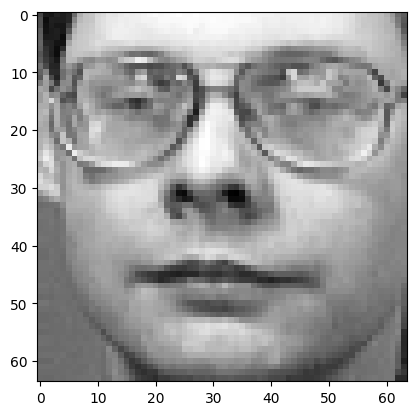

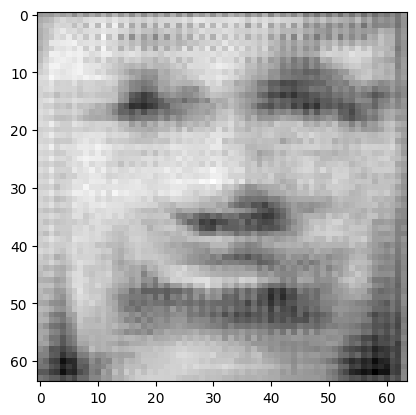

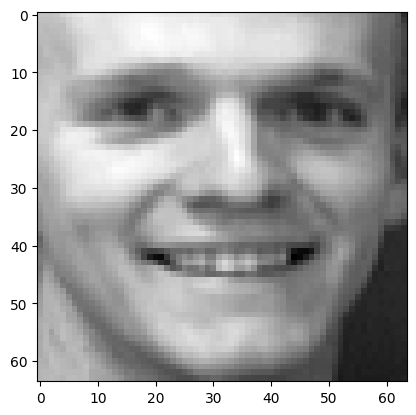

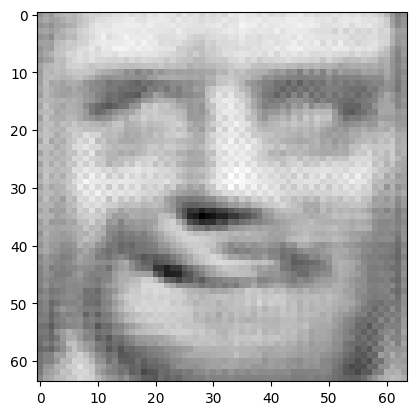

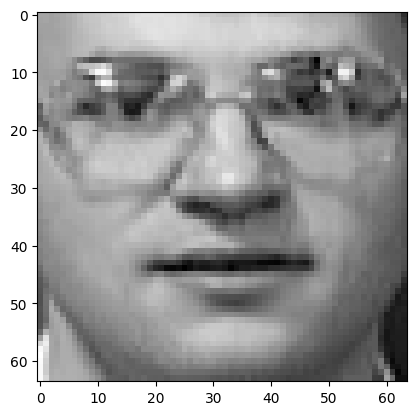

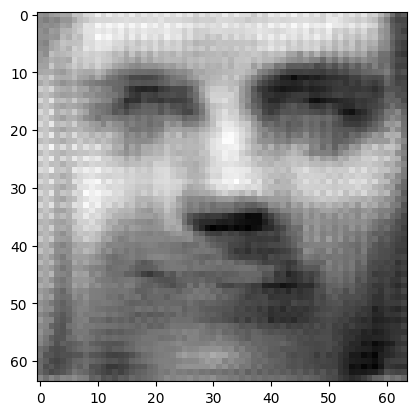

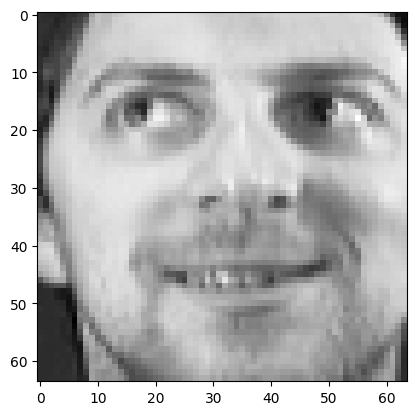

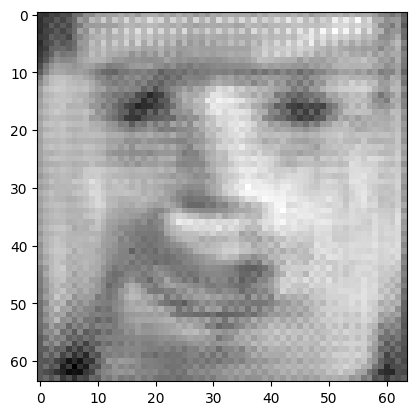

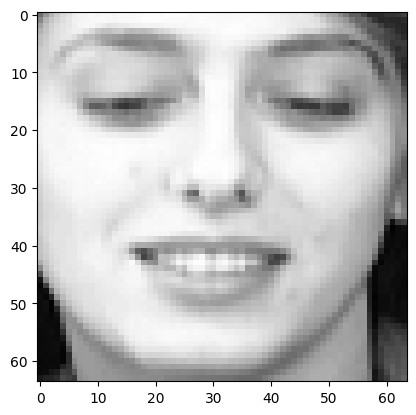

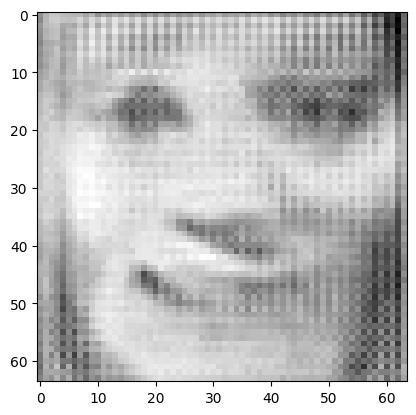

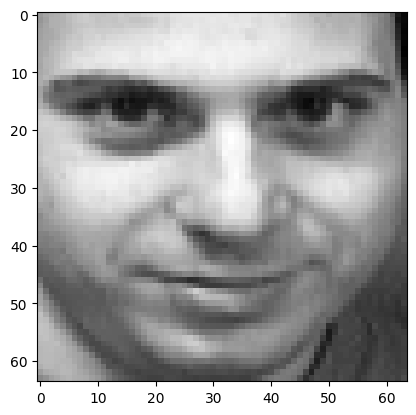

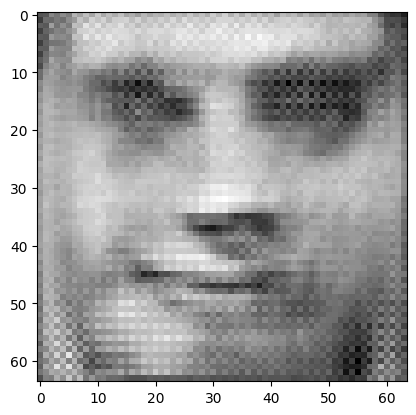

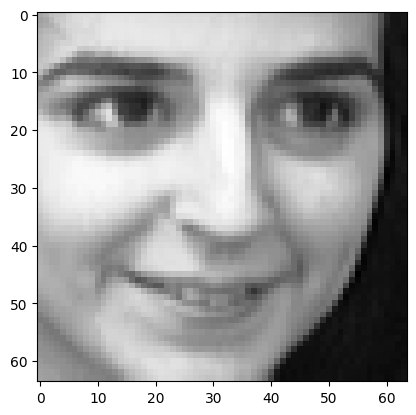

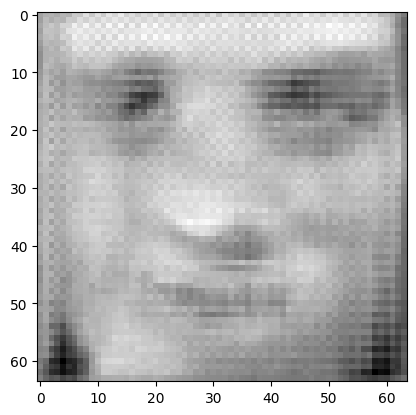

In [83]:
for i in range(10):
    label_to_picture(i)
    generated_image(i)


In [84]:
for i in range(10):
    evolve_generator(100, 0.001, 0.005, 0.99, 1)
    d, l = discriminator_make_dataset()
    train_discriminator_eps(discriminator, 30, 0.001, 0.01, d, l)

loss(generator):  9.267923736572266
loss(generator):  3.8927520751953124
loss(generator):  1.2412034034729005
loss(generator):  0.8600390434265137
loss(generator):  0.43618459701538087
loss(generator):  0.44729437828063967
loss(generator):  0.16458740234375
loss(generator):  0.10346469879150391
loss(generator):  0.0809000313282013
loss(generator):  0.06326965093612671
loss(generator):  0.06918010115623474
loss(generator):  0.06332272291183472
loss(generator):  0.04996001124382019
loss(generator):  0.049190711975097653
loss(generator):  0.05036453604698181
loss(generator):  0.04303843677043915
loss(generator):  0.039269599318504336
loss(generator):  0.046558958292007444
loss(generator):  0.04041597843170166
loss(generator):  0.03580312132835388
loss(generator):  0.03438077569007873
loss(generator):  0.035849693417549136
loss(generator):  0.02984650731086731
loss(generator):  0.03143313527107239
loss(generator):  0.03065446615219116
loss(generator):  0.030033916234970093
loss(generator):

400it [00:01, 325.21it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 43.812
epoch start:  1
training ...


400it [00:01, 278.75it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 1.353
epoch start:  2
training ...


400it [00:01, 283.19it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 1.152
epoch start:  3
training ...


400it [00:01, 324.48it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 1.163
epoch start:  4
training ...


400it [00:01, 325.11it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 1.179
epoch start:  5
training ...


400it [00:01, 311.43it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 1.192
epoch start:  6
training ...


400it [00:01, 294.48it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 1.246
epoch start:  7
training ...


400it [00:01, 268.18it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 1.250
epoch start:  8
training ...


400it [00:01, 330.48it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 1.215
epoch start:  9
training ...


400it [00:01, 325.84it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 1.197
epoch start:  10
training ...


400it [00:01, 325.09it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 1.208
epoch start:  11
training ...


400it [00:01, 317.89it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 1.196
epoch start:  12
training ...


400it [00:01, 312.67it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 1.203
epoch start:  13
training ...


400it [00:01, 327.16it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 1.197
epoch start:  14
training ...


400it [00:01, 319.35it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 1.153
epoch start:  15
training ...


400it [00:01, 312.13it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 1.119
epoch start:  16
training ...


400it [00:01, 318.63it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 1.124
epoch start:  17
training ...


400it [00:01, 322.31it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 1.113
epoch start:  18
training ...


400it [00:01, 328.27it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 1.076
epoch start:  19
training ...


400it [00:01, 324.80it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 1.077
epoch start:  20
training ...


400it [00:01, 335.33it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 1.053
epoch start:  21
training ...


400it [00:01, 324.91it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 1.015
epoch start:  22
training ...


400it [00:01, 316.61it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 1.027
epoch start:  23
training ...


400it [00:01, 315.52it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 1.000
epoch start:  24
training ...


400it [00:01, 335.08it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.968
epoch start:  25
training ...


400it [00:01, 331.45it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.959
epoch start:  26
training ...


400it [00:01, 329.19it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.941
epoch start:  27
training ...


400it [00:01, 320.60it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.945
epoch start:  28
training ...


400it [00:01, 324.04it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.925
epoch start:  29
training ...


400it [00:01, 324.80it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.918
loss(generator):  6.6978599548339846
loss(generator):  1.0774192810058594
loss(generator):  0.507566261291504
loss(generator):  0.24442565441131592
loss(generator):  0.21571853160858154
loss(generator):  0.18180837631225585
loss(generator):  0.1462637424468994
loss(generator):  0.12137149572372437
loss(generator):  0.117195725440979
loss(generator):  0.09710845947265626
loss(generator):  0.10685606002807617
loss(generator):  0.0904051423072815
loss(generator):  0.09449611902236939
loss(generator):  0.0884795606136322
loss(generator):  0.08414203524589539
loss(generator):  0.08557495474815369
loss(generator):  0.0779855191707611
loss(generator):  0.07230761051177978
loss(generator):  0.06586718559265137
loss(generator):  0.06502136588096619
loss(generator):  0.06957051753997803
loss(generator):  0.06056298613548279
loss(generator):  0.05365319848060608
loss(generator):  0.05888965725898743
loss(generator):  0.054656577110290525
loss(generator): 

400it [00:01, 352.31it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 84.358
epoch start:  1
training ...


400it [00:01, 319.19it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 2.217
epoch start:  2
training ...


400it [00:01, 342.63it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 0.793
epoch start:  3
training ...


400it [00:01, 331.70it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.710
epoch start:  4
training ...


400it [00:01, 318.98it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.687
epoch start:  5
training ...


400it [00:01, 334.71it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.733
epoch start:  6
training ...


400it [00:01, 338.95it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.734
epoch start:  7
training ...


400it [00:01, 325.51it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.771
epoch start:  8
training ...


400it [00:01, 327.35it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.736
epoch start:  9
training ...


400it [00:01, 341.95it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.735
epoch start:  10
training ...


400it [00:01, 338.22it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.696
epoch start:  11
training ...


400it [00:01, 328.47it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.729
epoch start:  12
training ...


400it [00:01, 327.06it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.737
epoch start:  13
training ...


400it [00:01, 333.86it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.698
epoch start:  14
training ...


400it [00:01, 332.60it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.680
epoch start:  15
training ...


400it [00:01, 333.32it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.724
epoch start:  16
training ...


400it [00:01, 324.07it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.712
epoch start:  17
training ...


400it [00:01, 309.04it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.730
epoch start:  18
training ...


400it [00:01, 313.86it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.713
epoch start:  19
training ...


400it [00:01, 326.10it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.706
epoch start:  20
training ...


400it [00:01, 329.71it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.695
epoch start:  21
training ...


400it [00:01, 330.40it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.675
epoch start:  22
training ...


400it [00:01, 338.94it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.772
epoch start:  23
training ...


400it [00:01, 331.71it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.666
epoch start:  24
training ...


400it [00:01, 332.73it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.680
epoch start:  25
training ...


400it [00:01, 327.11it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.693
epoch start:  26
training ...


400it [00:01, 322.36it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.708
epoch start:  27
training ...


400it [00:01, 318.31it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.655
epoch start:  28
training ...


400it [00:01, 332.78it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.695
epoch start:  29
training ...


400it [00:01, 331.47it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.690
loss(generator):  6.667989349365234
loss(generator):  0.17211114168167113
loss(generator):  0.0322440505027771
loss(generator):  0.020741476118564604
loss(generator):  0.0251539945602417
loss(generator):  0.019292965531349182
loss(generator):  0.016713450849056243
loss(generator):  0.01910569965839386
loss(generator):  0.01673389971256256
loss(generator):  0.015499572455883025
loss(generator):  0.01418202519416809
loss(generator):  0.012558050453662872
loss(generator):  0.011654792726039887
loss(generator):  0.010964775085449218
loss(generator):  0.008310546725988388
loss(generator):  0.008823659271001816
loss(generator):  0.009854994714260101
loss(generator):  0.00844382420182228
loss(generator):  0.008325356245040893
loss(generator):  0.008297691494226456
loss(generator):  0.009303102642297745
loss(generator):  0.009108497202396393
loss(generator):  0.008065707236528396
loss(generator):  0.008905299752950669
loss(generator):  0.00867892578244

400it [00:01, 310.62it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 232.221
epoch start:  1
training ...


400it [00:01, 330.65it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 106.292
epoch start:  2
training ...


400it [00:01, 339.33it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 22.610
epoch start:  3
training ...


400it [00:01, 333.28it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 1.164
epoch start:  4
training ...


400it [00:01, 326.45it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.782
epoch start:  5
training ...


400it [00:01, 322.14it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.732
epoch start:  6
training ...


400it [00:01, 328.53it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.717
epoch start:  7
training ...


400it [00:01, 332.30it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.750
epoch start:  8
training ...


400it [00:01, 337.51it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.778
epoch start:  9
training ...


400it [00:01, 317.75it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.815
epoch start:  10
training ...


400it [00:01, 330.54it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.757
epoch start:  11
training ...


400it [00:01, 336.75it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.769
epoch start:  12
training ...


400it [00:01, 316.94it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.811
epoch start:  13
training ...


400it [00:01, 321.59it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.820
epoch start:  14
training ...


400it [00:01, 313.70it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.783
epoch start:  15
training ...


400it [00:01, 330.50it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.771
epoch start:  16
training ...


400it [00:01, 330.82it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.854
epoch start:  17
training ...


400it [00:01, 321.93it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.815
epoch start:  18
training ...


400it [00:01, 326.37it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.809
epoch start:  19
training ...


400it [00:01, 289.17it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.852
epoch start:  20
training ...


400it [00:01, 324.69it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.834
epoch start:  21
training ...


400it [00:01, 324.09it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.845
epoch start:  22
training ...


400it [00:01, 323.20it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.813
epoch start:  23
training ...


400it [00:01, 292.09it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.809
epoch start:  24
training ...


400it [00:01, 330.11it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.804
epoch start:  25
training ...


400it [00:01, 328.93it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.846
epoch start:  26
training ...


400it [00:01, 330.44it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.805
epoch start:  27
training ...


400it [00:02, 186.76it/s]


Epoch: 28 | Time: 0m 2s	Train Loss: 0.797
epoch start:  28
training ...


400it [00:01, 326.32it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.821
epoch start:  29
training ...


400it [00:01, 327.29it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.830
loss(generator):  5.697182464599609
loss(generator):  0.15075995922088622
loss(generator):  0.05453912019729614
loss(generator):  0.03693593442440033
loss(generator):  0.026369589567184448
loss(generator):  0.02271505892276764
loss(generator):  0.022144724428653718
loss(generator):  0.01932794600725174
loss(generator):  0.017224237322807312
loss(generator):  0.012380259484052658
loss(generator):  0.01797759234905243
loss(generator):  0.016216373443603514
loss(generator):  0.013632600009441376
loss(generator):  0.011609357595443726
loss(generator):  0.01223689690232277
loss(generator):  0.008804816752672195
loss(generator):  0.010963502526283263
loss(generator):  0.010534735023975372
loss(generator):  0.008590946346521378
loss(generator):  0.009910151362419128
loss(generator):  0.008798056840896606
loss(generator):  0.010727308690547943
loss(generator):  0.010036269575357437
loss(generator):  0.0085684634745121
loss(generator):  0.00896230116486

400it [00:01, 329.35it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 267.172
epoch start:  1
training ...


400it [00:01, 333.64it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 63.257
epoch start:  2
training ...


400it [00:01, 333.08it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 3.035
epoch start:  3
training ...


400it [00:01, 333.40it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 0.914
epoch start:  4
training ...


400it [00:01, 329.91it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 0.746
epoch start:  5
training ...


400it [00:01, 313.74it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.756
epoch start:  6
training ...


400it [00:01, 332.73it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.735
epoch start:  7
training ...


400it [00:01, 328.88it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.757
epoch start:  8
training ...


400it [00:01, 331.73it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.795
epoch start:  9
training ...


400it [00:01, 328.82it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.737
epoch start:  10
training ...


400it [00:01, 322.72it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.771
epoch start:  11
training ...


400it [00:01, 339.51it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.769
epoch start:  12
training ...


400it [00:01, 331.76it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.735
epoch start:  13
training ...


400it [00:01, 329.85it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.877
epoch start:  14
training ...


400it [00:01, 328.75it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.729
epoch start:  15
training ...


400it [00:01, 327.78it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.757
epoch start:  16
training ...


400it [00:01, 288.06it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.810
epoch start:  17
training ...


400it [00:01, 319.15it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.744
epoch start:  18
training ...


400it [00:01, 324.01it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.795
epoch start:  19
training ...


400it [00:01, 327.14it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.872
epoch start:  20
training ...


400it [00:01, 318.54it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.750
epoch start:  21
training ...


400it [00:01, 330.85it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.742
epoch start:  22
training ...


400it [00:01, 329.11it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.777
epoch start:  23
training ...


400it [00:01, 272.69it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.945
epoch start:  24
training ...


400it [00:01, 321.93it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.766
epoch start:  25
training ...


400it [00:01, 324.76it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.779
epoch start:  26
training ...


400it [00:01, 328.58it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.755
epoch start:  27
training ...


400it [00:01, 324.66it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.833
epoch start:  28
training ...


400it [00:01, 317.47it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.823
epoch start:  29
training ...


400it [00:01, 330.00it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.762
loss(generator):  6.373952484130859
loss(generator):  0.7287133693695068
loss(generator):  0.046446210145950316
loss(generator):  0.0320116251707077
loss(generator):  0.02754998207092285
loss(generator):  0.016933469474315642
loss(generator):  0.015365438163280487
loss(generator):  0.015823142230510713
loss(generator):  0.01326209157705307
loss(generator):  0.011617583781480789
loss(generator):  0.012450013309717178
loss(generator):  0.012079484760761261
loss(generator):  0.010679906606674195
loss(generator):  0.009164800494909286
loss(generator):  0.009441828727722168
loss(generator):  0.009323371946811676
loss(generator):  0.0072516463696956635
loss(generator):  0.0077007442712783815
loss(generator):  0.007908255606889725
loss(generator):  0.008153919130563736
loss(generator):  0.007368574291467667
loss(generator):  0.007293574512004852
loss(generator):  0.005831007286906243
loss(generator):  0.006921496242284775
loss(generator):  0.008227983

400it [00:01, 330.54it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 246.173
epoch start:  1
training ...


400it [00:01, 244.66it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 156.837
epoch start:  2
training ...


400it [00:01, 338.35it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 107.317
epoch start:  3
training ...


400it [00:01, 340.27it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 18.229
epoch start:  4
training ...


400it [00:01, 338.22it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 1.178
epoch start:  5
training ...


400it [00:01, 323.19it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.917
epoch start:  6
training ...


400it [00:01, 329.02it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.862
epoch start:  7
training ...


400it [00:01, 328.85it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.770
epoch start:  8
training ...


400it [00:01, 247.35it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.940
epoch start:  9
training ...


400it [00:01, 327.80it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.784
epoch start:  10
training ...


400it [00:01, 321.58it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.757
epoch start:  11
training ...


400it [00:01, 306.10it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.827
epoch start:  12
training ...


400it [00:01, 326.58it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.815
epoch start:  13
training ...


400it [00:01, 317.67it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.853
epoch start:  14
training ...


400it [00:01, 325.67it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.839
epoch start:  15
training ...


400it [00:01, 322.68it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.810
epoch start:  16
training ...


400it [00:01, 323.81it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.814
epoch start:  17
training ...


400it [00:01, 326.35it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.804
epoch start:  18
training ...


400it [00:01, 318.25it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.834
epoch start:  19
training ...


400it [00:01, 319.79it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.851
epoch start:  20
training ...


400it [00:01, 319.86it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.827
epoch start:  21
training ...


400it [00:01, 327.70it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.883
epoch start:  22
training ...


400it [00:01, 319.99it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.832
epoch start:  23
training ...


400it [00:01, 325.84it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.810
epoch start:  24
training ...


400it [00:01, 313.58it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.821
epoch start:  25
training ...


400it [00:01, 310.59it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.795
epoch start:  26
training ...


400it [00:01, 329.29it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.891
epoch start:  27
training ...


400it [00:01, 330.86it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.881
epoch start:  28
training ...


400it [00:01, 323.25it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.840
epoch start:  29
training ...


400it [00:01, 319.32it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.831
loss(generator):  6.314273834228516
loss(generator):  0.15471621751785278
loss(generator):  0.04150805771350861
loss(generator):  0.02723546326160431
loss(generator):  0.025649189949035645
loss(generator):  0.022921845316886902
loss(generator):  0.01786956042051315
loss(generator):  0.020484842360019684
loss(generator):  0.022319377958774568
loss(generator):  0.020228148996829988
loss(generator):  0.019055680930614473
loss(generator):  0.01741509586572647
loss(generator):  0.01774838864803314
loss(generator):  0.01648203730583191
loss(generator):  0.013892409205436707
loss(generator):  0.017126631736755372
loss(generator):  0.012905308604240417
loss(generator):  0.015778650343418122
loss(generator):  0.012521998584270477
loss(generator):  0.012052655220031738
loss(generator):  0.01194402649998665
loss(generator):  0.010983601212501526
loss(generator):  0.010931555926799775
loss(generator):  0.010308074951171874
loss(generator):  0.0112920060753

400it [00:01, 311.65it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 313.975
epoch start:  1
training ...


400it [00:01, 347.30it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 207.725
epoch start:  2
training ...


400it [00:01, 344.17it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 169.848
epoch start:  3
training ...


400it [00:01, 333.74it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 149.651
epoch start:  4
training ...


400it [00:01, 329.23it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 73.951
epoch start:  5
training ...


400it [00:01, 336.79it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 70.548
epoch start:  6
training ...


400it [00:01, 281.66it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 274.936
epoch start:  7
training ...


400it [00:01, 333.40it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 114.269
epoch start:  8
training ...


400it [00:01, 315.34it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 129.959
epoch start:  9
training ...


400it [00:01, 319.88it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 97.927
epoch start:  10
training ...


400it [00:01, 308.11it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 29.727
epoch start:  11
training ...


400it [00:01, 326.03it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 1.930
epoch start:  12
training ...


400it [00:01, 317.18it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 1.111
epoch start:  13
training ...


400it [00:01, 319.38it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.889
epoch start:  14
training ...


400it [00:01, 330.29it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.931
epoch start:  15
training ...


400it [00:01, 330.51it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.814
epoch start:  16
training ...


400it [00:01, 325.71it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.794
epoch start:  17
training ...


400it [00:01, 330.83it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.864
epoch start:  18
training ...


400it [00:01, 331.66it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 1.027
epoch start:  19
training ...


400it [00:01, 330.40it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.837
epoch start:  20
training ...


400it [00:01, 324.08it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.810
epoch start:  21
training ...


400it [00:01, 329.55it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.847
epoch start:  22
training ...


400it [00:01, 315.48it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.871
epoch start:  23
training ...


400it [00:01, 328.70it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.869
epoch start:  24
training ...


400it [00:01, 313.78it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.811
epoch start:  25
training ...


400it [00:01, 334.66it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.902
epoch start:  26
training ...


400it [00:01, 320.10it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.858
epoch start:  27
training ...


400it [00:01, 316.55it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.821
epoch start:  28
training ...


400it [00:01, 312.61it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.840
epoch start:  29
training ...


400it [00:01, 273.64it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.855
loss(generator):  5.991560363769532
loss(generator):  0.3828292369842529
loss(generator):  0.10610942840576172
loss(generator):  0.0444349467754364
loss(generator):  0.03624156415462494
loss(generator):  0.029998868703842163
loss(generator):  0.02974255084991455
loss(generator):  0.024904122948646544
loss(generator):  0.01860959082841873
loss(generator):  0.01885410100221634
loss(generator):  0.016688643395900725
loss(generator):  0.019037505984306334
loss(generator):  0.0178799644112587
loss(generator):  0.018160174787044524
loss(generator):  0.015006014704704284
loss(generator):  0.013308395445346833
loss(generator):  0.013432574272155762
loss(generator):  0.014022406935691834
loss(generator):  0.013001033663749694
loss(generator):  0.010474339127540588
loss(generator):  0.011972299218177796
loss(generator):  0.009638303518295288
loss(generator):  0.013272805511951447
loss(generator):  0.008314120769500732
loss(generator):  0.0101938866078853

400it [00:01, 331.87it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 285.171
epoch start:  1
training ...


400it [00:01, 314.82it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 138.451
epoch start:  2
training ...


400it [00:01, 294.52it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 45.235
epoch start:  3
training ...


400it [00:01, 342.67it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 16.753
epoch start:  4
training ...


400it [00:01, 343.07it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 1.831
epoch start:  5
training ...


400it [00:01, 337.06it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.991
epoch start:  6
training ...


400it [00:01, 291.49it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.729
epoch start:  7
training ...


400it [00:01, 331.08it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.698
epoch start:  8
training ...


400it [00:01, 328.71it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.678
epoch start:  9
training ...


400it [00:01, 330.43it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.612
epoch start:  10
training ...


400it [00:01, 330.14it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.682
epoch start:  11
training ...


400it [00:01, 328.48it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.701
epoch start:  12
training ...


400it [00:01, 330.06it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.704
epoch start:  13
training ...


400it [00:01, 323.74it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.735
epoch start:  14
training ...


400it [00:01, 331.68it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.760
epoch start:  15
training ...


400it [00:01, 330.86it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.753
epoch start:  16
training ...


400it [00:01, 331.26it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.736
epoch start:  17
training ...


400it [00:01, 326.51it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.718
epoch start:  18
training ...


400it [00:01, 333.67it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.702
epoch start:  19
training ...


400it [00:01, 328.48it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.778
epoch start:  20
training ...


400it [00:01, 331.46it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.864
epoch start:  21
training ...


400it [00:01, 330.88it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.724
epoch start:  22
training ...


400it [00:01, 322.53it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.703
epoch start:  23
training ...


400it [00:01, 334.78it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.779
epoch start:  24
training ...


400it [00:01, 331.75it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.767
epoch start:  25
training ...


400it [00:01, 327.58it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.700
epoch start:  26
training ...


400it [00:01, 326.08it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.797
epoch start:  27
training ...


400it [00:01, 320.53it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.770
epoch start:  28
training ...


400it [00:01, 328.72it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.791
epoch start:  29
training ...


400it [00:01, 330.18it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.747
loss(generator):  6.670875549316406
loss(generator):  0.06602855324745179
loss(generator):  0.020621708035469054
loss(generator):  0.015415142476558685
loss(generator):  0.015911220014095305
loss(generator):  0.01415559947490692
loss(generator):  0.012642647325992584
loss(generator):  0.013387615978717803
loss(generator):  0.011184453219175338
loss(generator):  0.010005639493465423
loss(generator):  0.01041908860206604
loss(generator):  0.009043850004673004
loss(generator):  0.009056036174297333
loss(generator):  0.007558447867631912
loss(generator):  0.009387779980897903
loss(generator):  0.007834492623806
loss(generator):  0.008113078773021698
loss(generator):  0.006743885576725006
loss(generator):  0.006522213667631149
loss(generator):  0.007373566180467606
loss(generator):  0.007941798865795135
loss(generator):  0.006139494851231575
loss(generator):  0.0057738590985536575
loss(generator):  0.006729172170162201
loss(generator):  0.0071237184

400it [00:01, 327.39it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 281.071
epoch start:  1
training ...


400it [00:01, 327.28it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 134.099
epoch start:  2
training ...


400it [00:01, 329.45it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 84.049
epoch start:  3
training ...


400it [00:01, 330.24it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 22.720
epoch start:  4
training ...


400it [00:01, 329.49it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 3.952
epoch start:  5
training ...


400it [00:01, 326.97it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 0.840
epoch start:  6
training ...


400it [00:01, 332.43it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 0.686
epoch start:  7
training ...


400it [00:01, 265.23it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.692
epoch start:  8
training ...


400it [00:01, 327.84it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.670
epoch start:  9
training ...


400it [00:01, 323.52it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.771
epoch start:  10
training ...


400it [00:01, 330.90it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.759
epoch start:  11
training ...


400it [00:01, 327.54it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.757
epoch start:  12
training ...


400it [00:01, 324.27it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.802
epoch start:  13
training ...


400it [00:01, 313.19it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.719
epoch start:  14
training ...


400it [00:01, 324.63it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.756
epoch start:  15
training ...


400it [00:01, 331.04it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.801
epoch start:  16
training ...


400it [00:01, 321.63it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.813
epoch start:  17
training ...


400it [00:01, 299.15it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.794
epoch start:  18
training ...


400it [00:01, 330.04it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.822
epoch start:  19
training ...


400it [00:01, 323.54it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.801
epoch start:  20
training ...


400it [00:01, 325.19it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.752
epoch start:  21
training ...


400it [00:01, 322.77it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.789
epoch start:  22
training ...


400it [00:01, 327.03it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 88.997
epoch start:  23
training ...


400it [00:01, 326.91it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 38.099
epoch start:  24
training ...


400it [00:01, 327.94it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 1.503
epoch start:  25
training ...


400it [00:01, 331.03it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 0.871
epoch start:  26
training ...


400it [00:01, 329.06it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.697
epoch start:  27
training ...


400it [00:01, 327.02it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.738
epoch start:  28
training ...


400it [00:01, 327.43it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.706
epoch start:  29
training ...


400it [00:01, 323.20it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.723
loss(generator):  6.9182487487792965
loss(generator):  0.13479933738708497
loss(generator):  0.06257532835006714
loss(generator):  0.02656552493572235
loss(generator):  0.026899799704551697
loss(generator):  0.026737746596336365
loss(generator):  0.018213577568531036
loss(generator):  0.022772347927093504
loss(generator):  0.01540982574224472
loss(generator):  0.01904767006635666
loss(generator):  0.01283230185508728
loss(generator):  0.014291001856327057
loss(generator):  0.014810885488986968
loss(generator):  0.010808228701353072
loss(generator):  0.014053250849246978
loss(generator):  0.012012501060962678
loss(generator):  0.010727505385875701
loss(generator):  0.008656524866819382
loss(generator):  0.011854972690343857
loss(generator):  0.01107044592499733
loss(generator):  0.009422922134399414
loss(generator):  0.008777221292257309
loss(generator):  0.008319957554340363
loss(generator):  0.0084249846637249
loss(generator):  0.0086198650300

400it [00:01, 277.23it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 225.325
epoch start:  1
training ...


400it [00:01, 326.72it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 91.117
epoch start:  2
training ...


400it [00:01, 309.54it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 37.154
epoch start:  3
training ...


400it [00:01, 343.70it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 14.848
epoch start:  4
training ...


400it [00:01, 330.89it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 41.197
epoch start:  5
training ...


400it [00:01, 320.76it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 10.671
epoch start:  6
training ...


400it [00:01, 336.59it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 3.975
epoch start:  7
training ...


400it [00:01, 334.01it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 1.661
epoch start:  8
training ...


400it [00:01, 331.72it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 1.146
epoch start:  9
training ...


400it [00:01, 328.93it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 1.118
epoch start:  10
training ...


400it [00:01, 336.09it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 1.007
epoch start:  11
training ...


400it [00:01, 334.78it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.985
epoch start:  12
training ...


400it [00:01, 280.91it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.952
epoch start:  13
training ...


400it [00:01, 331.62it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.963
epoch start:  14
training ...


400it [00:01, 330.67it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 1.039
epoch start:  15
training ...


400it [00:01, 331.28it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.922
epoch start:  16
training ...


400it [00:01, 332.03it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.920
epoch start:  17
training ...


400it [00:01, 330.69it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.925
epoch start:  18
training ...


400it [00:01, 332.34it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.967
epoch start:  19
training ...


400it [00:01, 332.36it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 1.311
epoch start:  20
training ...


400it [00:01, 331.31it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 0.860
epoch start:  21
training ...


400it [00:01, 253.88it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.881
epoch start:  22
training ...


400it [00:01, 318.87it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 0.832
epoch start:  23
training ...


400it [00:01, 329.93it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.865
epoch start:  24
training ...


400it [00:01, 294.02it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.853
epoch start:  25
training ...


400it [00:01, 310.55it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 1.001
epoch start:  26
training ...


400it [00:01, 319.19it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.833
epoch start:  27
training ...


400it [00:01, 276.50it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 0.869
epoch start:  28
training ...


400it [00:01, 324.03it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.830
epoch start:  29
training ...


400it [00:01, 325.16it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 0.894
loss(generator):  6.169641494750977
loss(generator):  0.47416024208068847
loss(generator):  0.20580923557281494
loss(generator):  0.10814490318298339
loss(generator):  0.08052117824554443
loss(generator):  0.05215252637863159
loss(generator):  0.032952684164047244
loss(generator):  0.03581368923187256
loss(generator):  0.0341279536485672
loss(generator):  0.025800570845603943
loss(generator):  0.029106545448303222
loss(generator):  0.024400030076503754
loss(generator):  0.0257059246301651
loss(generator):  0.022262705862522124
loss(generator):  0.016579627990722656
loss(generator):  0.016081959009170532
loss(generator):  0.013062594830989838
loss(generator):  0.015898779034614563
loss(generator):  0.017768444120883943
loss(generator):  0.014520512521266937
loss(generator):  0.012203940749168396
loss(generator):  0.014165182411670686
loss(generator):  0.01366407573223114
loss(generator):  0.013215665519237519
loss(generator):  0.0113946273922920

400it [00:01, 338.84it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 220.594
epoch start:  1
training ...


400it [00:01, 344.59it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 97.621
epoch start:  2
training ...


400it [00:01, 338.47it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 51.352
epoch start:  3
training ...


400it [00:01, 335.11it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 37.959
epoch start:  4
training ...


400it [00:01, 327.92it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 30.724
epoch start:  5
training ...


400it [00:01, 315.14it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 6.998
epoch start:  6
training ...


400it [00:01, 340.54it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 1.928
epoch start:  7
training ...


400it [00:01, 335.50it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 0.820
epoch start:  8
training ...


400it [00:01, 326.69it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 0.846
epoch start:  9
training ...


400it [00:01, 335.09it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 0.854
epoch start:  10
training ...


400it [00:01, 328.22it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.891
epoch start:  11
training ...


400it [00:01, 328.75it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.917
epoch start:  12
training ...


400it [00:01, 327.44it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 0.848
epoch start:  13
training ...


400it [00:01, 320.39it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 1.023
epoch start:  14
training ...


400it [00:01, 329.68it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.903
epoch start:  15
training ...


400it [00:01, 327.98it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 0.925
epoch start:  16
training ...


400it [00:01, 331.08it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.954
epoch start:  17
training ...


400it [00:01, 317.45it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 0.915
epoch start:  18
training ...


400it [00:01, 332.09it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 0.970
epoch start:  19
training ...


400it [00:01, 330.68it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 0.923
epoch start:  20
training ...


400it [00:01, 326.64it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 1.016
epoch start:  21
training ...


400it [00:01, 325.71it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 0.956
epoch start:  22
training ...


400it [00:01, 322.76it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 1.029
epoch start:  23
training ...


400it [00:01, 318.97it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 0.961
epoch start:  24
training ...


400it [00:01, 319.88it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 0.947
epoch start:  25
training ...


400it [00:01, 316.41it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 1.001
epoch start:  26
training ...


400it [00:01, 321.96it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 0.838
epoch start:  27
training ...


400it [00:01, 330.24it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 1.049
epoch start:  28
training ...


400it [00:01, 302.66it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 0.985
epoch start:  29
training ...


400it [00:01, 287.82it/s]

Epoch: 30 | Time: 0m 1s	Train Loss: 0.902


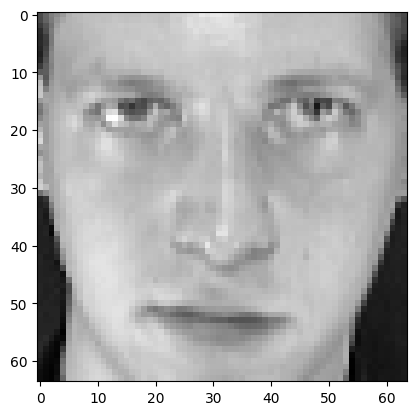

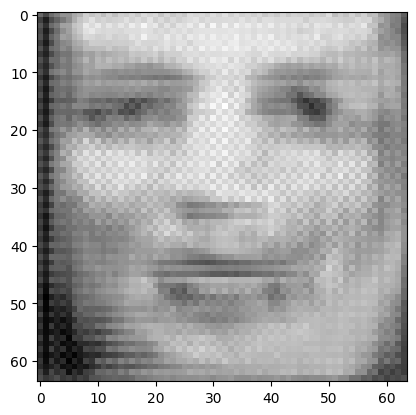

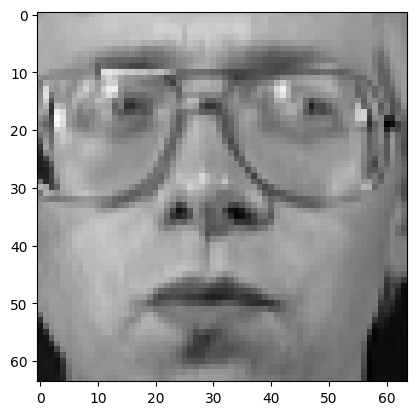

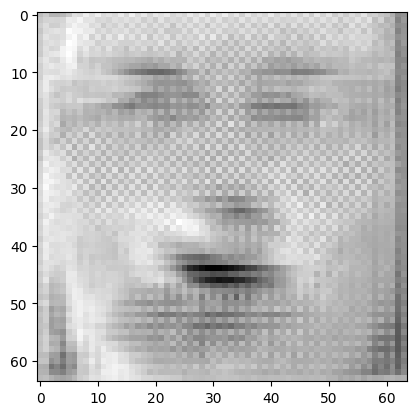

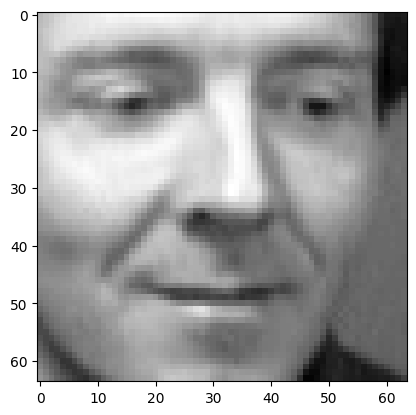

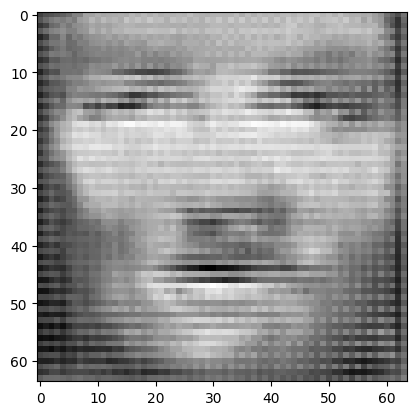

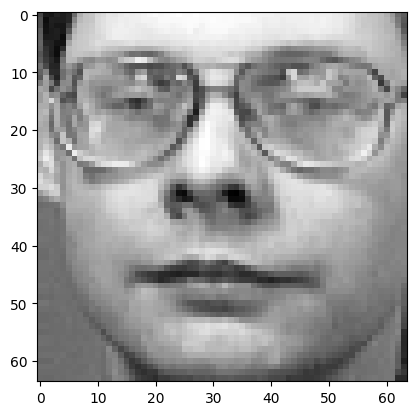

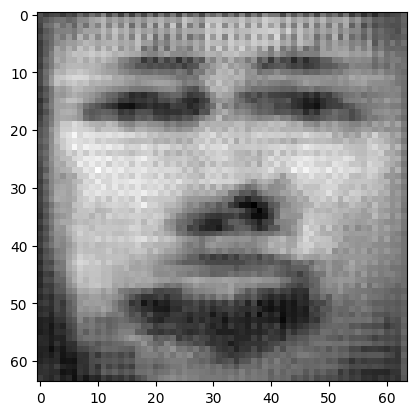

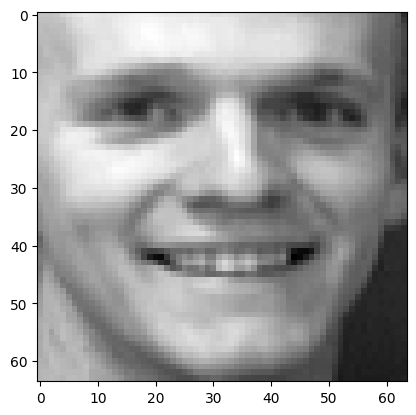

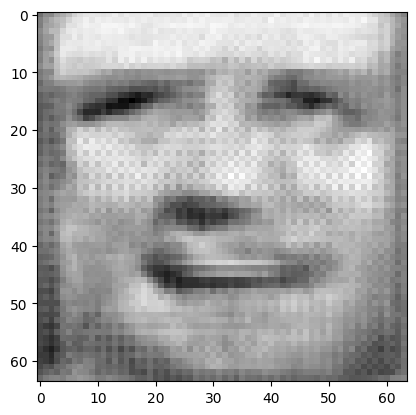

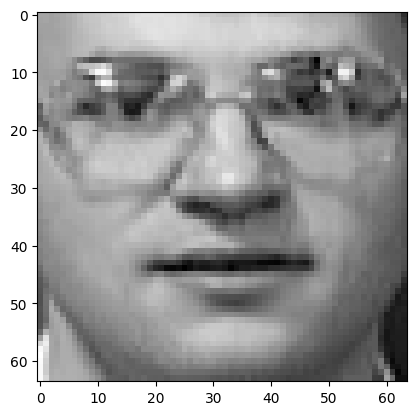

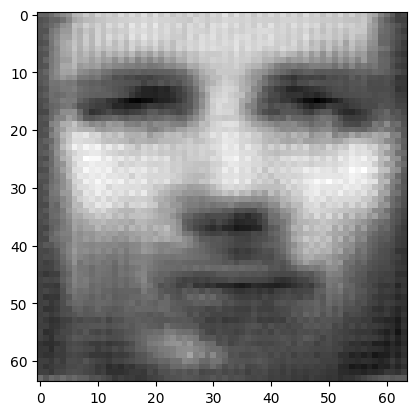

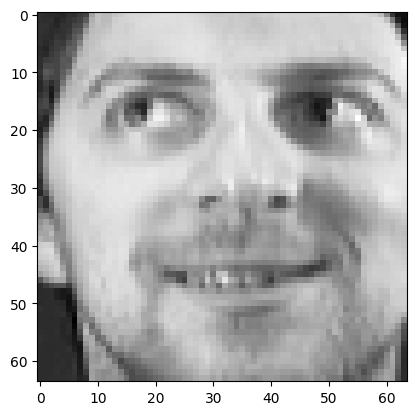

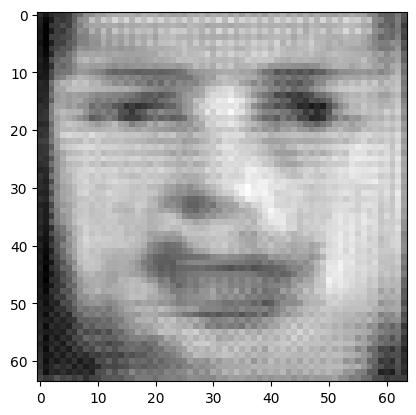

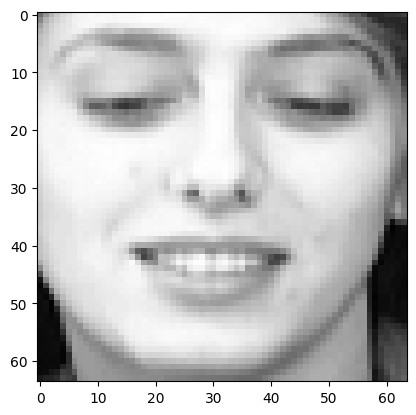

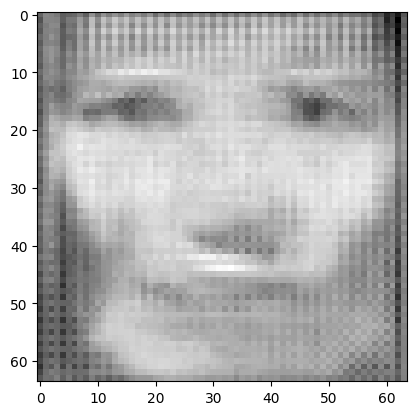

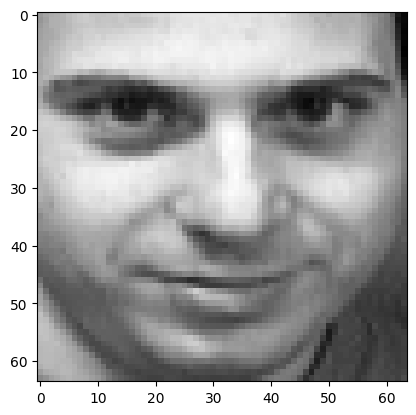

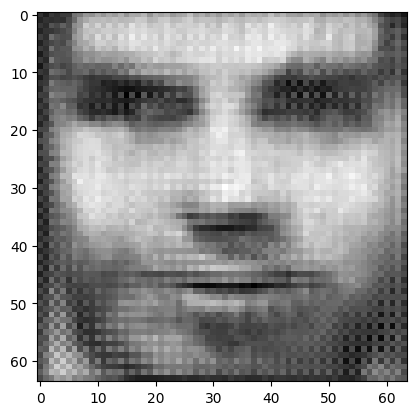

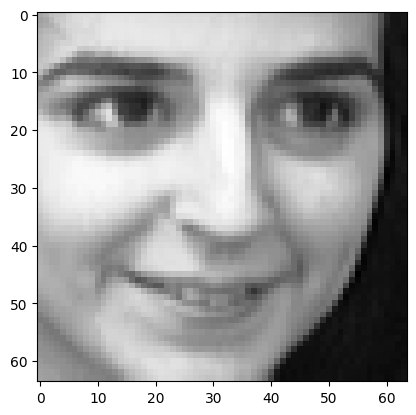

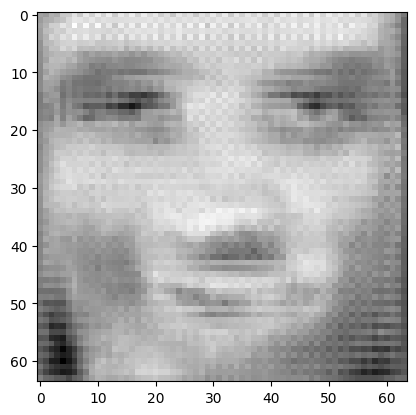

In [85]:
for i in range(10):
    label_to_picture(i)
    generated_image(i)

In [86]:
for i in range(10):
    evolve_generator(100, 0.001, 0.01, 0.99, 0.5)
    d, l = discriminator_make_dataset()
    train_discriminator_eps(discriminator, 30, 0.001, 0.01, d, l)

loss(generator):  3.0759357452392577
loss(generator):  0.34152162075042725
loss(generator):  0.0480169802904129
loss(generator):  0.03581319749355316
loss(generator):  0.03349660634994507
loss(generator):  0.026506146788597106
loss(generator):  0.027494323253631592
loss(generator):  0.025060471892356873
loss(generator):  0.02321462482213974
loss(generator):  0.017901715636253358
loss(generator):  0.016969352960586548
loss(generator):  0.030293756723403932
loss(generator):  0.019957582652568816
loss(generator):  0.021059392392635344
loss(generator):  0.02186288982629776
loss(generator):  0.016495996713638307
loss(generator):  0.018464665114879607
loss(generator):  0.012492422014474869
loss(generator):  0.012192962318658828
loss(generator):  0.013322456181049347
loss(generator):  0.011954548954963683
loss(generator):  0.01087377369403839
loss(generator):  0.012728327512741089
loss(generator):  0.008971739560365677
loss(generator):  0.011137151718139648
loss(generator):  0.009533761441707

400it [00:01, 344.88it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 259.220
epoch start:  1
training ...


400it [00:01, 351.04it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 193.422
epoch start:  2
training ...


400it [00:01, 351.72it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 148.215
epoch start:  3
training ...


400it [00:01, 351.33it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 110.744
epoch start:  4
training ...


400it [00:01, 350.26it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 76.554
epoch start:  5
training ...


400it [00:01, 351.56it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 45.398
epoch start:  6
training ...


400it [00:01, 351.67it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 43.367
epoch start:  7
training ...


400it [00:01, 351.56it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 8.150
epoch start:  8
training ...


400it [00:01, 350.70it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 1.597
epoch start:  9
training ...


400it [00:01, 351.62it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 2.127
epoch start:  10
training ...


400it [00:01, 351.59it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 0.968
epoch start:  11
training ...


400it [00:01, 351.11it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 0.883
epoch start:  12
training ...


400it [00:01, 377.63it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 1.086
epoch start:  13
training ...


400it [00:01, 383.62it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 0.731
epoch start:  14
training ...


400it [00:01, 385.29it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 0.867
epoch start:  15
training ...


400it [00:01, 384.05it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 1.034
epoch start:  16
training ...


400it [00:01, 384.99it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 0.835
epoch start:  17
training ...


400it [00:01, 384.32it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 1.079
epoch start:  18
training ...


400it [00:01, 383.60it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 1.075
epoch start:  19
training ...


400it [00:01, 384.73it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 1.097
epoch start:  20
training ...


400it [00:01, 383.89it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 1.096
epoch start:  21
training ...


400it [00:01, 383.23it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 1.010
epoch start:  22
training ...


400it [00:01, 381.07it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 1.277
epoch start:  23
training ...


400it [00:01, 384.64it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 263.369
epoch start:  24
training ...


400it [00:01, 381.15it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 77.546
epoch start:  25
training ...


400it [00:01, 381.92it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 34.733
epoch start:  26
training ...


400it [00:01, 382.61it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 22.289
epoch start:  27
training ...


400it [00:01, 382.84it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 38.495
epoch start:  28
training ...


400it [00:01, 385.17it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 7.366
epoch start:  29
training ...


400it [00:01, 386.02it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 1.559
loss(generator):  2.9521530151367186
loss(generator):  0.011303234845399857
loss(generator):  0.015676063299179078
loss(generator):  0.006389780342578888
loss(generator):  0.005817503109574318
loss(generator):  0.007679005712270736
loss(generator):  0.0068034067749977115
loss(generator):  0.004468646645545959
loss(generator):  0.0041497815400362015
loss(generator):  0.0059044182300567625
loss(generator):  0.004076698049902916
loss(generator):  0.0049284715205430984
loss(generator):  0.003140886127948761
loss(generator):  0.0052174065262079235
loss(generator):  0.003356758877635002
loss(generator):  0.003959272801876068
loss(generator):  0.004341516271233558
loss(generator):  0.0035560712218284606
loss(generator):  0.0033490024507045746
loss(generator):  0.009197565168142319
loss(generator):  0.0033033519983291628
loss(generator):  0.0027271561324596406
loss(generator):  0.003483007475733757
loss(generator):  0.003007054701447487
loss(generator)

400it [00:01, 358.99it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 302.382
epoch start:  1
training ...


400it [00:01, 361.23it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.864
epoch start:  2
training ...


400it [00:01, 352.81it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.140
epoch start:  3
training ...


400it [00:01, 354.59it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 277.950
epoch start:  4
training ...


400it [00:01, 339.17it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.921
epoch start:  5
training ...


400it [00:01, 352.57it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.137
epoch start:  6
training ...


400it [00:01, 360.45it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 278.114
epoch start:  7
training ...


400it [00:01, 364.12it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 278.419
epoch start:  8
training ...


400it [00:01, 357.28it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.793
epoch start:  9
training ...


400it [00:01, 361.36it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 278.020
epoch start:  10
training ...


400it [00:01, 352.30it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.109
epoch start:  11
training ...


400it [00:01, 335.06it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 277.768
epoch start:  12
training ...


400it [00:01, 338.09it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 278.252
epoch start:  13
training ...


400it [00:01, 337.26it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 278.041
epoch start:  14
training ...


400it [00:01, 338.23it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 278.046
epoch start:  15
training ...


400it [00:01, 337.86it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.047
epoch start:  16
training ...


400it [00:01, 337.95it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 278.329
epoch start:  17
training ...


400it [00:01, 329.52it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 277.817
epoch start:  18
training ...


400it [00:00, 414.14it/s]


Epoch: 19 | Time: 0m 0s	Train Loss: 278.238
epoch start:  19
training ...


400it [00:01, 337.15it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 278.280
epoch start:  20
training ...


400it [00:01, 339.90it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 278.207
epoch start:  21
training ...


400it [00:01, 339.81it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.109
epoch start:  22
training ...


400it [00:01, 339.64it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 278.487
epoch start:  23
training ...


400it [00:01, 339.70it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 277.901
epoch start:  24
training ...


400it [00:01, 348.92it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 278.253
epoch start:  25
training ...


400it [00:01, 349.51it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 277.802
epoch start:  26
training ...


400it [00:01, 348.11it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.146
epoch start:  27
training ...


400it [00:01, 339.70it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 278.084
epoch start:  28
training ...


400it [00:01, 339.48it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 277.863
epoch start:  29
training ...


400it [00:01, 349.80it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 278.126
loss(generator):  0.34557514190673827
loss(generator):  0.34572246074676516
loss(generator):  0.3452160120010376
loss(generator):  0.3451793909072876
loss(generator):  0.3451464891433716
loss(generator):  0.3452799320220947
loss(generator):  0.34561762809753416
loss(generator):  0.34525036811828613
loss(generator):  0.3451551914215088
loss(generator):  0.3452859163284302
loss(generator):  0.34524943828582766
loss(generator):  0.3454643964767456
loss(generator):  0.3452575445175171
loss(generator):  0.34528179168701173
loss(generator):  0.3453016519546509
loss(generator):  0.34554443359375
loss(generator):  0.3454725742340088
loss(generator):  0.34542436599731446
loss(generator):  0.34533617496490476
loss(generator):  0.3452043056488037
loss(generator):  0.3450929164886475
loss(generator):  0.3455777406692505
loss(generator):  0.3453144788742065
loss(generator):  0.3453566789627075
loss(generator):  0.34504530429840086
loss(generator):  0.3449

400it [00:01, 319.86it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 277.865
epoch start:  1
training ...


400it [00:01, 306.47it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.929
epoch start:  2
training ...


400it [00:01, 271.40it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.383
epoch start:  3
training ...


400it [00:01, 306.95it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 277.830
epoch start:  4
training ...


400it [00:01, 307.96it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.786
epoch start:  5
training ...


400it [00:01, 291.58it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.106
epoch start:  6
training ...


400it [00:01, 317.08it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 278.602
epoch start:  7
training ...


400it [00:01, 308.37it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 278.257
epoch start:  8
training ...


400it [00:01, 286.29it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.553
epoch start:  9
training ...


400it [00:01, 321.29it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 278.484
epoch start:  10
training ...


400it [00:01, 318.77it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.174
epoch start:  11
training ...


400it [00:01, 322.98it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 278.167
epoch start:  12
training ...


400it [00:01, 308.59it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 277.958
epoch start:  13
training ...


400it [00:01, 305.27it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 278.121
epoch start:  14
training ...


400it [00:01, 318.16it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.201
epoch start:  15
training ...


400it [00:01, 316.04it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.106
epoch start:  16
training ...


400it [00:01, 297.39it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 278.217
epoch start:  17
training ...


400it [00:01, 324.88it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.023
epoch start:  18
training ...


400it [00:01, 329.39it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 277.772
epoch start:  19
training ...


400it [00:01, 305.68it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 278.094
epoch start:  20
training ...


400it [00:01, 305.68it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 277.976
epoch start:  21
training ...


400it [00:01, 318.32it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.197
epoch start:  22
training ...


400it [00:01, 317.82it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 277.888
epoch start:  23
training ...


400it [00:01, 314.34it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 277.806
epoch start:  24
training ...


400it [00:01, 301.84it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 277.726
epoch start:  25
training ...


400it [00:01, 312.77it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 278.093
epoch start:  26
training ...


400it [00:01, 293.31it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.004
epoch start:  27
training ...


400it [00:01, 286.86it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 278.137
epoch start:  28
training ...


400it [00:01, 285.96it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 278.017
epoch start:  29
training ...


400it [00:01, 330.19it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 278.036
loss(generator):  0.36460037231445314
loss(generator):  0.36447625160217284
loss(generator):  0.3642162799835205
loss(generator):  0.3642359495162964
loss(generator):  0.3644059658050537
loss(generator):  0.3643075704574585
loss(generator):  0.36451015472412107
loss(generator):  0.3642693758010864
loss(generator):  0.3644312620162964
loss(generator):  0.3645186901092529
loss(generator):  0.3642133712768555
loss(generator):  0.3642455577850342
loss(generator):  0.36428868770599365
loss(generator):  0.36437511444091797
loss(generator):  0.3642745494842529
loss(generator):  0.3644555568695068
loss(generator):  0.36432244777679446
loss(generator):  0.364253306388855
loss(generator):  0.3642536163330078
loss(generator):  0.36444907188415526
loss(generator):  0.36459181308746336
loss(generator):  0.36432685852050783
loss(generator):  0.3642331838607788
loss(generator):  0.3642996311187744
loss(generator):  0.3644124507904053
loss(generator):  0.364

400it [00:01, 311.96it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 278.505
epoch start:  1
training ...


400it [00:01, 329.74it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 278.163
epoch start:  2
training ...


400it [00:01, 330.60it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.213
epoch start:  3
training ...


400it [00:01, 288.69it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 277.952
epoch start:  4
training ...


400it [00:01, 305.06it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 278.232
epoch start:  5
training ...


400it [00:01, 316.47it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.124
epoch start:  6
training ...


400it [00:01, 325.12it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 278.035
epoch start:  7
training ...


400it [00:01, 319.34it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 278.066
epoch start:  8
training ...


400it [00:01, 312.44it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 278.068
epoch start:  9
training ...


400it [00:01, 326.73it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 277.976
epoch start:  10
training ...


400it [00:01, 322.20it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.028
epoch start:  11
training ...


400it [00:01, 323.01it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 278.166
epoch start:  12
training ...


400it [00:01, 312.17it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 278.047
epoch start:  13
training ...


400it [00:01, 319.93it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 278.158
epoch start:  14
training ...


400it [00:01, 328.36it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.709
epoch start:  15
training ...


400it [00:01, 327.64it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.196
epoch start:  16
training ...


400it [00:01, 317.23it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 276.946
epoch start:  17
training ...


400it [00:01, 317.16it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.068
epoch start:  18
training ...


400it [00:01, 312.58it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 278.418
epoch start:  19
training ...


400it [00:01, 327.44it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 278.102
epoch start:  20
training ...


400it [00:01, 299.07it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 277.973
epoch start:  21
training ...


400it [00:01, 319.06it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.205
epoch start:  22
training ...


400it [00:01, 327.59it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 278.100
epoch start:  23
training ...


400it [00:01, 333.68it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 278.252
epoch start:  24
training ...


400it [00:01, 315.90it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 277.895
epoch start:  25
training ...


400it [00:01, 315.88it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 277.915
epoch start:  26
training ...


400it [00:01, 316.84it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.181
epoch start:  27
training ...


400it [00:01, 298.17it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 278.225
epoch start:  28
training ...


400it [00:01, 311.49it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 277.894
epoch start:  29
training ...


400it [00:01, 328.30it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 277.770
loss(generator):  0.3303723096847534
loss(generator):  0.3303019285202026
loss(generator):  0.3303095579147339
loss(generator):  0.33042809963226316
loss(generator):  0.33036973476409914
loss(generator):  0.3303881883621216
loss(generator):  0.33043975830078126
loss(generator):  0.330490779876709
loss(generator):  0.33040966987609866
loss(generator):  0.3304636240005493
loss(generator):  0.33046903610229494
loss(generator):  0.3302515745162964
loss(generator):  0.3303274631500244
loss(generator):  0.3304351568222046
loss(generator):  0.3302575349807739
loss(generator):  0.33039107322692873
loss(generator):  0.33033807277679444
loss(generator):  0.33034276962280273
loss(generator):  0.3302099943161011
loss(generator):  0.33050010204315183
loss(generator):  0.33028326034545896
loss(generator):  0.3304381132125854
loss(generator):  0.33045783042907717
loss(generator):  0.3302288055419922
loss(generator):  0.33040485382080076
loss(generator):  0.

400it [00:01, 314.21it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 277.818
epoch start:  1
training ...


400it [00:01, 318.37it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.976
epoch start:  2
training ...


400it [00:01, 289.43it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 277.872
epoch start:  3
training ...


400it [00:01, 316.28it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 278.092
epoch start:  4
training ...


400it [00:01, 322.99it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 278.032
epoch start:  5
training ...


400it [00:01, 321.57it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.243
epoch start:  6
training ...


400it [00:01, 298.20it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 278.034
epoch start:  7
training ...


400it [00:01, 313.39it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 277.757
epoch start:  8
training ...


400it [00:01, 302.08it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.118
epoch start:  9
training ...


400it [00:01, 303.67it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 278.187
epoch start:  10
training ...


400it [00:01, 305.70it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 277.781
epoch start:  11
training ...


400it [00:01, 297.29it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 277.899
epoch start:  12
training ...


400it [00:01, 319.19it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 277.672
epoch start:  13
training ...


400it [00:01, 311.14it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 277.957
epoch start:  14
training ...


400it [00:01, 290.49it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.907
epoch start:  15
training ...


400it [00:01, 307.20it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.048
epoch start:  16
training ...


400it [00:01, 313.69it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 277.960
epoch start:  17
training ...


400it [00:01, 325.12it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.199
epoch start:  18
training ...


400it [00:01, 311.65it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 277.992
epoch start:  19
training ...


400it [00:01, 323.95it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 277.832
epoch start:  20
training ...


400it [00:01, 324.84it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 278.170
epoch start:  21
training ...


400it [00:01, 325.86it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 277.952
epoch start:  22
training ...


400it [00:01, 316.87it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 278.347
epoch start:  23
training ...


400it [00:01, 302.33it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 278.109
epoch start:  24
training ...


400it [00:01, 314.13it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 277.928
epoch start:  25
training ...


400it [00:01, 320.57it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 278.265
epoch start:  26
training ...


400it [00:01, 306.42it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.247
epoch start:  27
training ...


400it [00:01, 316.58it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 278.025
epoch start:  28
training ...


400it [00:01, 327.02it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 278.101
epoch start:  29
training ...


400it [00:01, 324.14it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 277.843
loss(generator):  0.3614732503890991
loss(generator):  0.3613384962081909
loss(generator):  0.3613274097442627
loss(generator):  0.361429238319397
loss(generator):  0.3613356828689575
loss(generator):  0.36136317253112793
loss(generator):  0.36135909557342527
loss(generator):  0.3615253210067749
loss(generator):  0.36149356365203855
loss(generator):  0.361362624168396
loss(generator):  0.36136751174926757
loss(generator):  0.36131792068481444
loss(generator):  0.36135072708129884
loss(generator):  0.36142303943634035
loss(generator):  0.36148486137390134
loss(generator):  0.3613231658935547
loss(generator):  0.36125736236572265
loss(generator):  0.36156654357910156
loss(generator):  0.36162819862365725
loss(generator):  0.3613953828811646
loss(generator):  0.3612856388092041
loss(generator):  0.36142497062683104
loss(generator):  0.36130499839782715
loss(generator):  0.36129601001739503
loss(generator):  0.36124486923217775
loss(generator):  

400it [00:01, 336.77it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 278.178
epoch start:  1
training ...


400it [00:01, 325.85it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.998
epoch start:  2
training ...


400it [00:01, 328.31it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.118
epoch start:  3
training ...


400it [00:01, 328.08it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 278.152
epoch start:  4
training ...


400it [00:01, 332.01it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.407
epoch start:  5
training ...


400it [00:01, 330.42it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.339
epoch start:  6
training ...


400it [00:01, 332.61it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 277.769
epoch start:  7
training ...


400it [00:01, 310.10it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 278.401
epoch start:  8
training ...


400it [00:01, 321.05it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.903
epoch start:  9
training ...


400it [00:01, 285.34it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 277.687
epoch start:  10
training ...


400it [00:01, 314.66it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.170
epoch start:  11
training ...


400it [00:01, 308.97it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 278.103
epoch start:  12
training ...


400it [00:01, 333.47it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 277.939
epoch start:  13
training ...


400it [00:01, 319.30it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 278.015
epoch start:  14
training ...


400it [00:01, 327.87it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 278.126
epoch start:  15
training ...


400it [00:01, 312.20it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 277.801
epoch start:  16
training ...


400it [00:01, 321.41it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 277.867
epoch start:  17
training ...


400it [00:01, 325.32it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.431
epoch start:  18
training ...


400it [00:01, 323.01it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 278.175
epoch start:  19
training ...


400it [00:01, 298.36it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 277.626
epoch start:  20
training ...


400it [00:01, 326.73it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 278.157
epoch start:  21
training ...


400it [00:01, 333.33it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.334
epoch start:  22
training ...


400it [00:01, 304.17it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 278.413
epoch start:  23
training ...


400it [00:01, 320.45it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 278.290
epoch start:  24
training ...


400it [00:01, 317.51it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 278.399
epoch start:  25
training ...


400it [00:01, 328.53it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 277.750
epoch start:  26
training ...


400it [00:01, 327.39it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.144
epoch start:  27
training ...


400it [00:01, 292.43it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 277.840
epoch start:  28
training ...


400it [00:01, 331.08it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 278.008
epoch start:  29
training ...


400it [00:01, 317.79it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 278.419
loss(generator):  0.34097001552581785
loss(generator):  0.3409961938858032
loss(generator):  0.3408814907073975
loss(generator):  0.3408663272857666
loss(generator):  0.3409051179885864
loss(generator):  0.34083993434906007
loss(generator):  0.3408404111862183
loss(generator):  0.34094359874725344
loss(generator):  0.3408712863922119
loss(generator):  0.34089112281799316
loss(generator):  0.3408865690231323
loss(generator):  0.3409202337265015
loss(generator):  0.3408837080001831
loss(generator):  0.34091668128967284
loss(generator):  0.3410217761993408
loss(generator):  0.34087913036346434
loss(generator):  0.340906023979187
loss(generator):  0.3409276485443115
loss(generator):  0.34081079959869387
loss(generator):  0.3409062385559082
loss(generator):  0.3407461166381836
loss(generator):  0.34086060523986816
loss(generator):  0.3408311605453491
loss(generator):  0.3409519910812378
loss(generator):  0.34088749885559083
loss(generator):  0.340

400it [00:01, 327.48it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 278.152
epoch start:  1
training ...


400it [00:01, 325.32it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 278.016
epoch start:  2
training ...


400it [00:01, 313.87it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.133
epoch start:  3
training ...


400it [00:01, 321.47it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 278.085
epoch start:  4
training ...


400it [00:01, 334.73it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.169
epoch start:  5
training ...


400it [00:01, 321.83it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.144
epoch start:  6
training ...


400it [00:01, 335.78it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 277.979
epoch start:  7
training ...


400it [00:01, 337.60it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 278.168
epoch start:  8
training ...


400it [00:01, 338.26it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 278.181
epoch start:  9
training ...


400it [00:01, 322.50it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 278.658
epoch start:  10
training ...


400it [00:01, 324.05it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.066
epoch start:  11
training ...


400it [00:01, 332.63it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 278.147
epoch start:  12
training ...


400it [00:01, 326.24it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 277.740
epoch start:  13
training ...


400it [00:01, 320.59it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 277.741
epoch start:  14
training ...


400it [00:01, 317.82it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.994
epoch start:  15
training ...


400it [00:01, 330.92it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 277.860
epoch start:  16
training ...


400it [00:01, 331.93it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 278.756
epoch start:  17
training ...


400it [00:01, 316.63it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.039
epoch start:  18
training ...


400it [00:01, 319.54it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 277.801
epoch start:  19
training ...


400it [00:01, 328.47it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 278.052
epoch start:  20
training ...


400it [00:01, 317.40it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 278.052
epoch start:  21
training ...


400it [00:01, 312.90it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.144
epoch start:  22
training ...


400it [00:01, 301.93it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 278.148
epoch start:  23
training ...


400it [00:01, 312.81it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 278.054
epoch start:  24
training ...


400it [00:01, 314.68it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 278.352
epoch start:  25
training ...


400it [00:01, 302.23it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 278.291
epoch start:  26
training ...


400it [00:01, 311.06it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.004
epoch start:  27
training ...


400it [00:01, 306.09it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 277.876
epoch start:  28
training ...


400it [00:01, 325.65it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 278.074
epoch start:  29
training ...


400it [00:01, 311.23it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 278.188
loss(generator):  0.34903573989868164
loss(generator):  0.3492610931396484
loss(generator):  0.3491403579711914
loss(generator):  0.3490649700164795
loss(generator):  0.34897890090942385
loss(generator):  0.3490208625793457
loss(generator):  0.3490541934967041
loss(generator):  0.349013090133667
loss(generator):  0.34924993515014646
loss(generator):  0.34922099113464355
loss(generator):  0.3491217613220215
loss(generator):  0.349075984954834
loss(generator):  0.3491110324859619
loss(generator):  0.34913129806518556
loss(generator):  0.3490710735321045
loss(generator):  0.34908294677734375
loss(generator):  0.34909749031066895
loss(generator):  0.3490943908691406
loss(generator):  0.3491011619567871
loss(generator):  0.34908332824707033
loss(generator):  0.3491237640380859
loss(generator):  0.3491250514984131
loss(generator):  0.349058198928833
loss(generator):  0.3491832256317139
loss(generator):  0.34908251762390136
loss(generator):  0.34911

400it [00:01, 306.68it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 278.079
epoch start:  1
training ...


400it [00:01, 317.58it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.840
epoch start:  2
training ...


400it [00:01, 323.73it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 277.763
epoch start:  3
training ...


400it [00:01, 333.25it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 278.574
epoch start:  4
training ...


400it [00:01, 322.79it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.922
epoch start:  5
training ...


400it [00:01, 328.82it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.369
epoch start:  6
training ...


400it [00:01, 333.97it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 277.387
epoch start:  7
training ...


400it [00:01, 318.96it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 278.382
epoch start:  8
training ...


400it [00:01, 325.52it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.998
epoch start:  9
training ...


400it [00:01, 322.27it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 277.712
epoch start:  10
training ...


400it [00:01, 332.77it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.147
epoch start:  11
training ...


400it [00:01, 333.70it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 277.818
epoch start:  12
training ...


400it [00:01, 334.67it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 277.485
epoch start:  13
training ...


400it [00:01, 332.27it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 277.894
epoch start:  14
training ...


400it [00:01, 331.11it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 278.137
epoch start:  15
training ...


400it [00:01, 315.46it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.253
epoch start:  16
training ...


400it [00:01, 327.32it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 277.830
epoch start:  17
training ...


400it [00:01, 323.09it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.133
epoch start:  18
training ...


400it [00:01, 329.61it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 277.755
epoch start:  19
training ...


400it [00:01, 307.75it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 278.239
epoch start:  20
training ...


400it [00:01, 305.54it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 277.519
epoch start:  21
training ...


400it [00:01, 323.43it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.355
epoch start:  22
training ...


400it [00:01, 329.54it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 278.245
epoch start:  23
training ...


400it [00:01, 307.78it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 277.876
epoch start:  24
training ...


400it [00:01, 330.31it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 277.447
epoch start:  25
training ...


400it [00:01, 330.13it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 278.253
epoch start:  26
training ...


400it [00:01, 330.98it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 277.963
epoch start:  27
training ...


400it [00:01, 314.89it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 277.793
epoch start:  28
training ...


400it [00:01, 328.14it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 278.190
epoch start:  29
training ...


400it [00:01, 330.38it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 277.864
loss(generator):  0.37649025917053225
loss(generator):  0.3765873908996582
loss(generator):  0.3765772819519043
loss(generator):  0.37655799388885497
loss(generator):  0.3765512466430664
loss(generator):  0.376505184173584
loss(generator):  0.37663748264312746
loss(generator):  0.37660529613494875
loss(generator):  0.37659354209899903
loss(generator):  0.3765303134918213
loss(generator):  0.3764476776123047
loss(generator):  0.37655932903289796
loss(generator):  0.37660791873931887
loss(generator):  0.37651045322418214
loss(generator):  0.37654273509979247
loss(generator):  0.3765550136566162
loss(generator):  0.3765424251556396
loss(generator):  0.3766416311264038
loss(generator):  0.37657938003540037
loss(generator):  0.3765603542327881
loss(generator):  0.37651791572570803
loss(generator):  0.37646100521087644
loss(generator):  0.3765485048294067
loss(generator):  0.37659173011779784
loss(generator):  0.3765189409255981
loss(generator):  0

400it [00:01, 324.38it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 277.888
epoch start:  1
training ...


400it [00:01, 321.78it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.867
epoch start:  2
training ...


400it [00:01, 331.28it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.344
epoch start:  3
training ...


400it [00:01, 330.71it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 278.014
epoch start:  4
training ...


400it [00:01, 329.38it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 278.326
epoch start:  5
training ...


400it [00:01, 315.82it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 277.959
epoch start:  6
training ...


400it [00:01, 324.06it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 277.764
epoch start:  7
training ...


400it [00:01, 321.42it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 277.846
epoch start:  8
training ...


400it [00:01, 324.63it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 278.027
epoch start:  9
training ...


400it [00:01, 328.95it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 278.148
epoch start:  10
training ...


400it [00:01, 334.30it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.384
epoch start:  11
training ...


400it [00:01, 337.83it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 277.954
epoch start:  12
training ...


400it [00:01, 330.12it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 278.254
epoch start:  13
training ...


400it [00:01, 321.75it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 278.066
epoch start:  14
training ...


400it [00:01, 326.01it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.763
epoch start:  15
training ...


400it [00:01, 270.94it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.162
epoch start:  16
training ...


400it [00:01, 289.65it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 278.015
epoch start:  17
training ...


400it [00:01, 328.92it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.285
epoch start:  18
training ...


400it [00:01, 294.13it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 277.960
epoch start:  19
training ...


400it [00:01, 334.56it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 277.867
epoch start:  20
training ...


400it [00:01, 332.65it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 277.870
epoch start:  21
training ...


400it [00:01, 325.40it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.173
epoch start:  22
training ...


400it [00:01, 334.84it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 277.968
epoch start:  23
training ...


400it [00:01, 333.71it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 277.876
epoch start:  24
training ...


400it [00:01, 330.43it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 278.276
epoch start:  25
training ...


400it [00:01, 328.61it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 278.405
epoch start:  26
training ...


400it [00:01, 323.90it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 278.001
epoch start:  27
training ...


400it [00:01, 337.91it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 278.099
epoch start:  28
training ...


400it [00:01, 335.75it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 278.203
epoch start:  29
training ...


400it [00:01, 332.67it/s]


Epoch: 30 | Time: 0m 1s	Train Loss: 278.176
loss(generator):  0.35030694007873536
loss(generator):  0.3502072811126709
loss(generator):  0.3502535343170166
loss(generator):  0.35029258728027346
loss(generator):  0.350218391418457
loss(generator):  0.35025830268859864
loss(generator):  0.3502096652984619
loss(generator):  0.3503528594970703
loss(generator):  0.3502347469329834
loss(generator):  0.35025849342346194
loss(generator):  0.35018649101257326
loss(generator):  0.35032215118408205
loss(generator):  0.3501894950866699
loss(generator):  0.3502517223358154
loss(generator):  0.35036392211914064
loss(generator):  0.3502297878265381
loss(generator):  0.35022602081298826
loss(generator):  0.3502816677093506
loss(generator):  0.35018229484558105
loss(generator):  0.3502694606781006
loss(generator):  0.35019850730895996
loss(generator):  0.35017824172973633
loss(generator):  0.35020923614501953
loss(generator):  0.3501733303070068
loss(generator):  0.3502213001251221
loss(generator):  0.

400it [00:01, 324.85it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 277.821
epoch start:  1
training ...


400it [00:01, 326.77it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 278.291
epoch start:  2
training ...


400it [00:01, 346.53it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 278.233
epoch start:  3
training ...


400it [00:01, 339.25it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 277.743
epoch start:  4
training ...


400it [00:01, 289.88it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.697
epoch start:  5
training ...


400it [00:01, 337.44it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 278.033
epoch start:  6
training ...


400it [00:01, 337.05it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 278.071
epoch start:  7
training ...


400it [00:01, 331.06it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 277.928
epoch start:  8
training ...


400it [00:01, 326.61it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.883
epoch start:  9
training ...


400it [00:01, 333.21it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 277.874
epoch start:  10
training ...


400it [00:01, 336.16it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 278.006
epoch start:  11
training ...


400it [00:01, 341.54it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 278.269
epoch start:  12
training ...


400it [00:01, 325.87it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 278.047
epoch start:  13
training ...


400it [00:01, 327.18it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 278.352
epoch start:  14
training ...


400it [00:01, 330.45it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.504
epoch start:  15
training ...


400it [00:01, 319.70it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 278.144
epoch start:  16
training ...


400it [00:01, 325.36it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 278.056
epoch start:  17
training ...


400it [00:01, 342.08it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 278.116
epoch start:  18
training ...


400it [00:01, 339.90it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 278.461
epoch start:  19
training ...


400it [00:01, 341.30it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 278.030
epoch start:  20
training ...


400it [00:01, 298.61it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 278.328
epoch start:  21
training ...


400it [00:01, 339.27it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 278.158
epoch start:  22
training ...


400it [00:01, 308.58it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 277.354
epoch start:  23
training ...


400it [00:01, 340.90it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 278.137
epoch start:  24
training ...


400it [00:01, 301.81it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 277.840
epoch start:  25
training ...


400it [00:01, 337.52it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 277.968
epoch start:  26
training ...


400it [00:01, 344.44it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 277.920
epoch start:  27
training ...


400it [00:01, 339.42it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 277.970
epoch start:  28
training ...


400it [00:01, 328.33it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 277.728
epoch start:  29
training ...


400it [00:01, 335.15it/s]

Epoch: 30 | Time: 0m 1s	Train Loss: 277.764


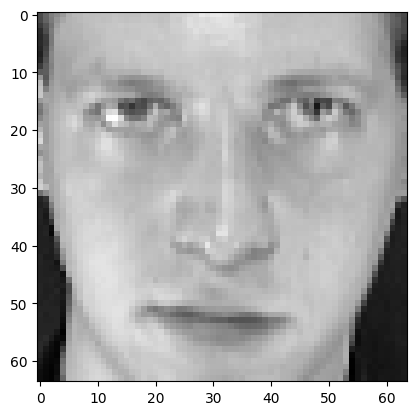

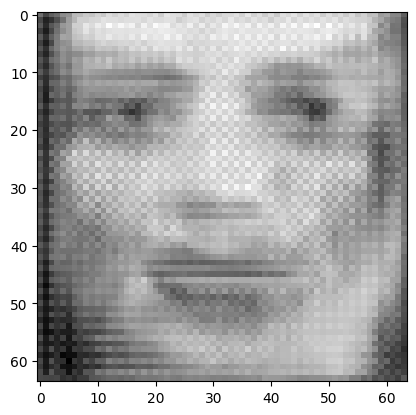

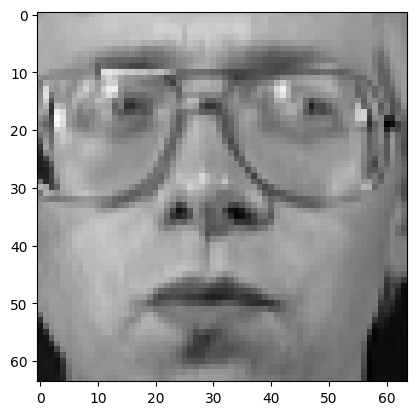

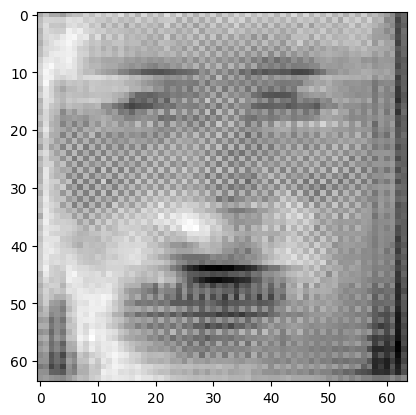

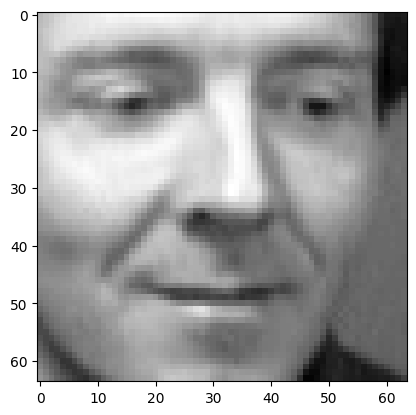

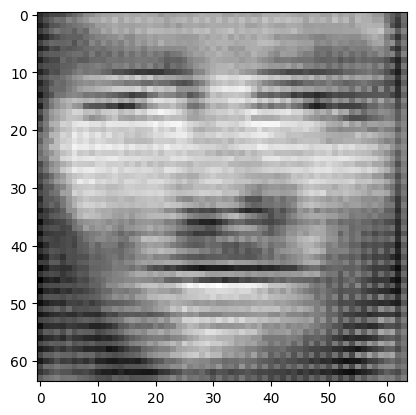

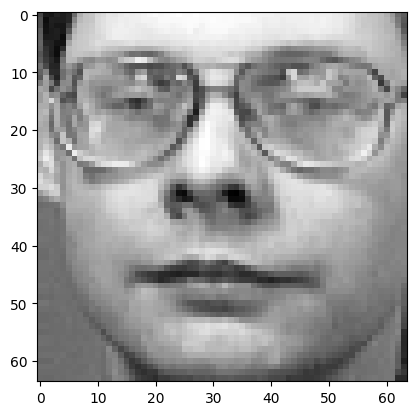

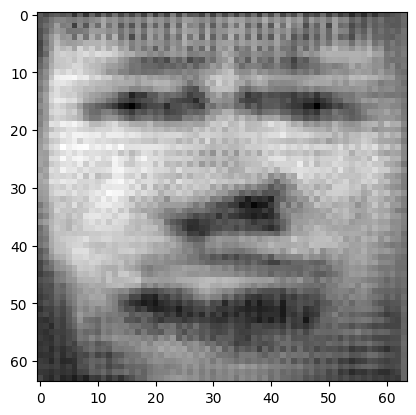

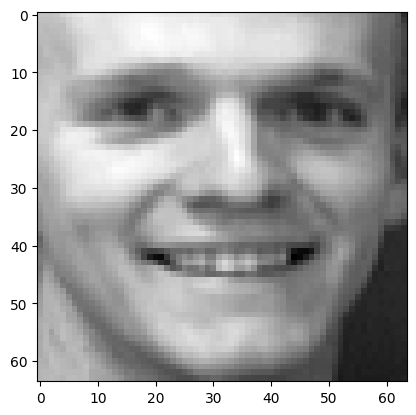

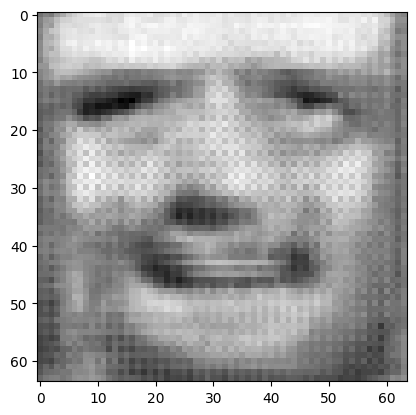

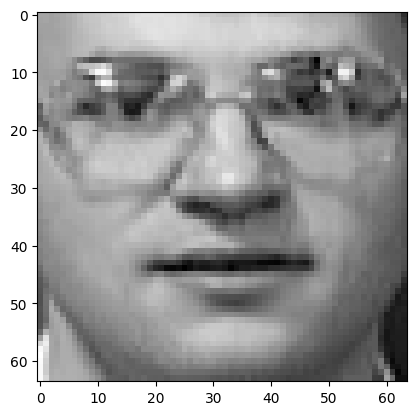

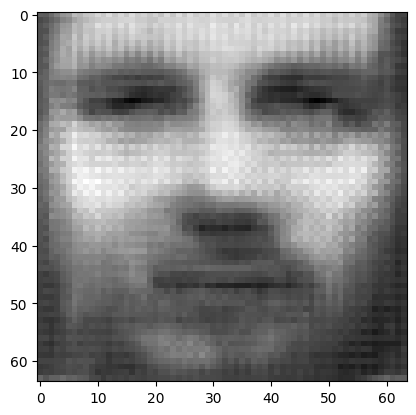

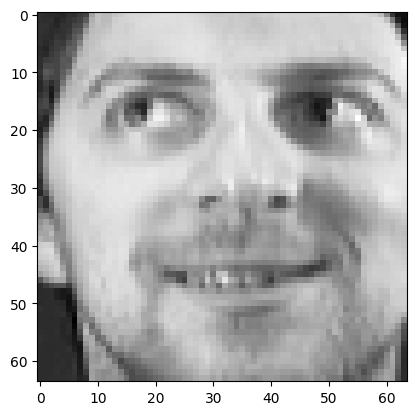

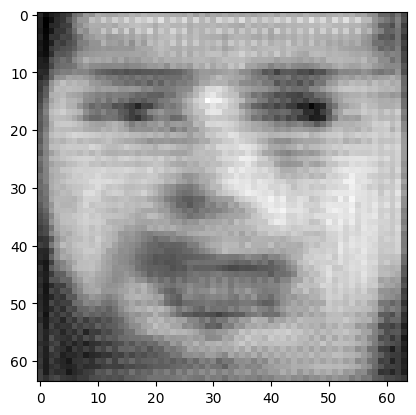

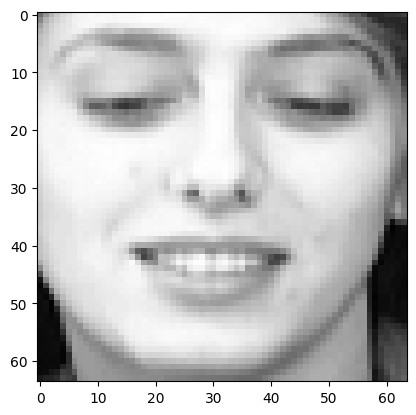

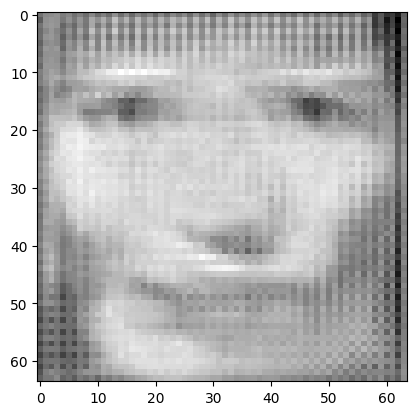

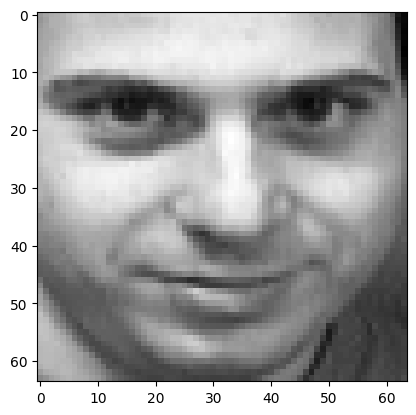

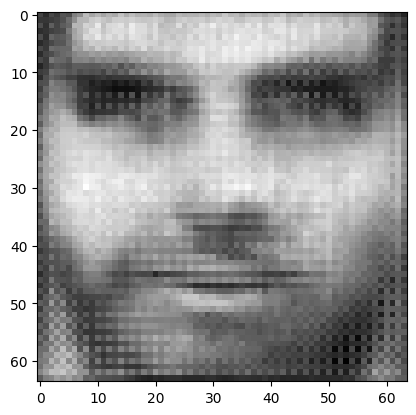

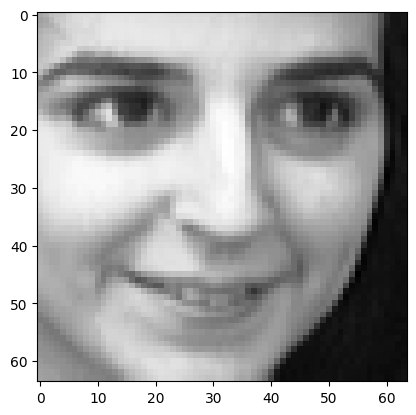

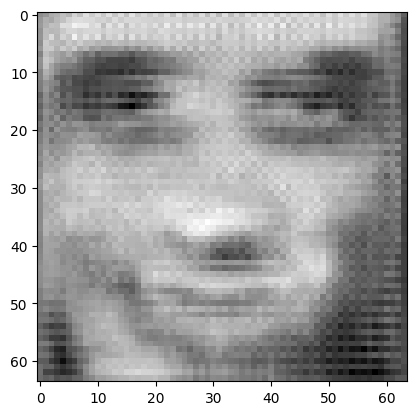

In [87]:
for i in range(10):
    label_to_picture(i)
    generated_image(i)

In [88]:
# prevouis, discriminator does not converge
# now we specifically train the discriminator

In [93]:
train_discriminator_eps(discriminator, 30, 0.0001, 0.0001, d, l)

epoch start:  0
training ...


400it [00:01, 324.24it/s]


Epoch: 01 | Time: 0m 1s	Train Loss: 277.351
epoch start:  1
training ...


400it [00:01, 358.23it/s]


Epoch: 02 | Time: 0m 1s	Train Loss: 277.338
epoch start:  2
training ...


400it [00:01, 331.54it/s]


Epoch: 03 | Time: 0m 1s	Train Loss: 277.340
epoch start:  3
training ...


400it [00:01, 331.56it/s]


Epoch: 04 | Time: 0m 1s	Train Loss: 277.403
epoch start:  4
training ...


400it [00:01, 327.17it/s]


Epoch: 05 | Time: 0m 1s	Train Loss: 277.349
epoch start:  5
training ...


400it [00:01, 332.38it/s]


Epoch: 06 | Time: 0m 1s	Train Loss: 277.336
epoch start:  6
training ...


400it [00:01, 338.25it/s]


Epoch: 07 | Time: 0m 1s	Train Loss: 277.364
epoch start:  7
training ...


400it [00:01, 342.72it/s]


Epoch: 08 | Time: 0m 1s	Train Loss: 277.378
epoch start:  8
training ...


400it [00:01, 331.98it/s]


Epoch: 09 | Time: 0m 1s	Train Loss: 277.338
epoch start:  9
training ...


400it [00:01, 330.34it/s]


Epoch: 10 | Time: 0m 1s	Train Loss: 277.380
epoch start:  10
training ...


400it [00:01, 305.65it/s]


Epoch: 11 | Time: 0m 1s	Train Loss: 277.370
epoch start:  11
training ...


400it [00:01, 341.86it/s]


Epoch: 12 | Time: 0m 1s	Train Loss: 277.337
epoch start:  12
training ...


400it [00:01, 336.17it/s]


Epoch: 13 | Time: 0m 1s	Train Loss: 277.338
epoch start:  13
training ...


400it [00:01, 327.80it/s]


Epoch: 14 | Time: 0m 1s	Train Loss: 277.355
epoch start:  14
training ...


400it [00:01, 288.80it/s]


Epoch: 15 | Time: 0m 1s	Train Loss: 277.340
epoch start:  15
training ...


400it [00:01, 285.55it/s]


Epoch: 16 | Time: 0m 1s	Train Loss: 277.341
epoch start:  16
training ...


400it [00:01, 324.65it/s]


Epoch: 17 | Time: 0m 1s	Train Loss: 277.370
epoch start:  17
training ...


400it [00:01, 331.10it/s]


Epoch: 18 | Time: 0m 1s	Train Loss: 277.344
epoch start:  18
training ...


400it [00:01, 330.72it/s]


Epoch: 19 | Time: 0m 1s	Train Loss: 277.382
epoch start:  19
training ...


400it [00:01, 329.54it/s]


Epoch: 20 | Time: 0m 1s	Train Loss: 277.333
epoch start:  20
training ...


400it [00:01, 339.46it/s]


Epoch: 21 | Time: 0m 1s	Train Loss: 277.333
epoch start:  21
training ...


400it [00:01, 330.25it/s]


Epoch: 22 | Time: 0m 1s	Train Loss: 277.352
epoch start:  22
training ...


400it [00:01, 335.59it/s]


Epoch: 23 | Time: 0m 1s	Train Loss: 277.348
epoch start:  23
training ...


400it [00:01, 332.56it/s]


Epoch: 24 | Time: 0m 1s	Train Loss: 277.338
epoch start:  24
training ...


400it [00:01, 332.97it/s]


Epoch: 25 | Time: 0m 1s	Train Loss: 277.348
epoch start:  25
training ...


400it [00:01, 330.76it/s]


Epoch: 26 | Time: 0m 1s	Train Loss: 277.335
epoch start:  26
training ...


400it [00:01, 335.87it/s]


Epoch: 27 | Time: 0m 1s	Train Loss: 277.332
epoch start:  27
training ...


400it [00:01, 332.76it/s]


Epoch: 28 | Time: 0m 1s	Train Loss: 277.360
epoch start:  28
training ...


400it [00:01, 335.05it/s]


Epoch: 29 | Time: 0m 1s	Train Loss: 277.351
epoch start:  29
training ...


400it [00:01, 317.95it/s]

Epoch: 30 | Time: 0m 1s	Train Loss: 277.337


In [94]:
# discriminator still does not converge
# may need to increase the model complexity for the discriminator and try

# The current generator's result is somewhat decent 

In [95]:
torch.save(generator.state_dict(), 'best_generator.pt')
torch.save(discriminator.state_dict(), 'best_discriminator.pt')